# Heroes of Might and Magic III
## Creature analysis : model for AI value

### 0. Project info and goal

**Introduction :**

You are part of the team that is about to developed the <i>**"Horn of the Abyss"**</i> mod, by adding a new fraction, in one of the best strategic games to have ever been made - **"Heroes of Might and Magic III"**. The game is known to be paradoxically balanced whilst imbalanced. So in order to make the mod feel like a real part of the game, save time and be able to set the right-ish characteristics of each of the new creatures, you should take a carefull look at what each race offers. Throughout the research you stumble upon a peculiar parameter which, if not set accordingly, will mess up with the AI's recognition of the units whilst in battle, and battle is the essence of the game. This parameter is called <i>**"AI Value"**</i>. It tells the computer how to behave on the battlefield and how to prioritize. Since you couldn't find the formula to calculate it, it seems like a good idea to make a statistical analysis and try to come up with a model. A good marker for the importance of a creature is its value. Such parameter may help get a feel for each unit's ***ai_value***, even though it has nothing to do with combat.


**To do :**

1. Find/build/scrape a dataframe with the creatures from the game.
2. Set it up so it would be easy to work with.
3. Look at what each fraction offers to get a feel of the type of units.
4. Come up with hypothesis and build models over the statistics.
5. Compare models and with data and find out if there really are formulas.


**Expectations :**

Since Linear Regression is a very simple, yet great prediction tool, it would be best to try and transform the data in a way that we can make use of it. Since there are less than 150 creatures in the game, it would be hard to make a good model and certainly impossible to make one for the creatures that have strong special abilities (which probably add noise to the data). Unfortunately most of them have some sort of ability, so the end result should be a model that gives somewhat good predictions based on parameters, excluding the abilities as they cannot be accurately modelled. Given the small dataset and the task, some of the decisions will be made after visual analysis and knowledge of the game.


**Sources :**

The project is influenced by these [dataframes, visualizations](https://www.kaggle.com/daynearthur/heroes-of-might-and-magic-3-units) and [plots](https://www.python-graph-gallery.com).

### 1. Import libraries and dependencies

In [1]:
%matplotlib inline

In [2]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

### 2. Get famiilar with the data, organize it and clean it

In [3]:
url_github_dataset = 'https://raw.githubusercontent.com/alexander-dakov/Heroes_3_unit_analysis/main/H3Units.csv'

units = pd.read_csv(url_github_dataset)
units

,Unit_name,Castle,Level,Attack,Defence,Minimum Damage,Maximum Damage,Health,Speed,Growth,AI_Value,Gold,Additional_item,Special_abilities
0,Pikeman,Castle,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting
1,Halberdier,Castle,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting
2,Archer,Castle,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots)
3,Marksman,Castle,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack"
4,Griffin,Castle,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Enchanter,Neutral,6,17,12,14,14,30,9,2,1210,750,0,"Ranged(32shots),Nomeleeandobstaclepenalty,Spel..."
137,FaerieDragon,Neutral,7,20,20,20,30,500,15,1,19580,10000,"Gem,8","Dragon,Flying,Spellcaster,MagicMirror"
138,RustDragon,Neutral,7,30,30,50,50,750,17,1,26433,15000,"Sulfur,14","Dragon,Flying,Breath,Acidbreath"
139,CrystalDragon,Neutral,7,40,40,60,75,800,16,1,39338,20000,"Crystal,10","Dragon,Crystalgeneration,Resistance+20%,Unliving"


Lets see what types each feature holds :

In [4]:
units.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141 entries, 0 to 140
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Unit_name          141 non-null    object
 1   Castle             141 non-null    object
 2   Level              141 non-null    object
 3   Attack             141 non-null    int64 
 4   Defence            141 non-null    int64 
 5   Minimum Damage     141 non-null    int64 
 6   Maximum Damage     141 non-null    int64 
 7   Health             141 non-null    int64 
 8   Speed              141 non-null    int64 
 9   Growth             141 non-null    int64 
 10  AI_Value           141 non-null    int64 
 11  Gold               141 non-null    int64 
 12  Additional_item    141 non-null    object
 13  Special_abilities  141 non-null    object
dtypes: int64(9), object(5)
memory usage: 15.5+ KB


Check the min/max values (all should be positive) and the count. Mean and standard deviation are not important here because of the wide range :

In [5]:
units.describe()

,Attack,Defence,Minimum Damage,Maximum Damage,Health,Speed,Growth,AI_Value,Gold
count,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000,141.000000
mean,11.659574,10.843972,11.262411,15.992908,78.085106,7.418440,5.730496,2417.624113,1236.489362
std,6.992680,7.207420,13.339868,16.784132,138.142136,3.466484,4.702400,7908.489944,3403.613560
min,1.000000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,15.000000,10.000000
25%,7.000000,6.000000,2.000000,4.000000,15.000000,5.000000,2.000000,203.000000,150.000000
50%,10.000000,10.000000,6.000000,9.000000,30.000000,7.000000,4.000000,517.000000,350.000000
75%,15.000000,13.000000,15.000000,20.000000,75.000000,9.000000,8.000000,1547.000000,850.000000
max,50.000000,50.000000,70.000000,80.000000,1000.000000,21.000000,25.000000,78845.000000,30000.000000


Lets see if all the units have different name :

In [6]:
if len(units.Unit_name.unique()) == units.shape[0] :
  print("All units have unique names.")
else :
  print("Some units have repeating names! Find them and fix them!")

All units have unique names.


This means that no duplicates should be found. Lets prove it :

In [7]:
if units.shape == units.drop_duplicates().shape:
  print("Dataset had no duplicates.")
else :
  print("Dataset had duplicates! Go back and analyze them!")

Dataset had no duplicates.


Check for wrong/missing names of towns - ***Castle, Inferno, Tower, Dungeon,  Conflux, Necropolis, Rampart, Stronghold, Fortress***
and a neutral town to which all neutral creatures 'belong' :

In [8]:
units.Castle.unique()

array(['Castle', 'Rampart', 'Tower', 'Inferno', 'Necropolis', 'Dungeon',
       'Stronghold', 'Fortress', 'Conflux', 'Neutral'], dtype=object)

Check for wrong/missing levels of creatures - should be 1-7 :

In [9]:
units.Level.unique()

array(['1', '1+', '2', '2+', '3', '3+', '4', '4+', '5', '5+', '6', '6+',
       '7', '7+', '3+*', '4+*', '5+*'], dtype=object)

The **'+'** and **'+*'** signs mark upgraded units.

All columns apart from **"Additional_item"** and **"Special_abilities"** were checked. For the purposes of this project, if any of the unchecked columns contain : a string value, a whitespace or "0" - it will not pose a threat.

This means that the data can be considered tidy.

In [10]:
units.columns

Index(['Unit_name', 'Castle', 'Level', 'Attack', 'Defence', 'Minimum Damage',
       'Maximum Damage', 'Health', 'Speed', 'Growth', 'AI_Value', 'Gold',
       'Additional_item', 'Special_abilities'],
      dtype='object')

Its time for a little set up so it would be easier to work with it. Columns need to be renamed - all should start with a lower-case letter and some will recieve new names, to fit their purpose better:
- **Unit_name** -> ***creature***
- **Castle** -> ***town*** (because there is a fraction/town called 'Castle')
- **Attack** -> ***att***
- **Defence** -> ***def***
- **Minimum Damage** -> ***min_dmg***
- **Maximum Damage** -> ***max_dmg***
- **Health** -> ***hp***
- **Additional_item** -> ***resources*** (different from gold, that are needed to recruit for the army)
- **Special_abilities** -> ***abilities***

In [11]:
units = units.rename(columns = {'Unit_name' : 'unit',
                                'Castle' : 'town',
                                'Level' : 'level',
                                'Attack' : 'att',
                                'Defence' : 'def',
                                'Minimum Damage' : 'min_dmg',
                                'Maximum Damage' : 'max_dmg',
                                'Health' : 'hp',
                                'Speed' : 'speed',
                                'Growth' : 'growth',
                                'AI_Value' : 'ai_value',
                                'Gold' : 'gold' ,
                                'Additional_item' : 'resources',
                                'Special_abilities' : 'abilities'})

units

,unit,town,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,Pikeman,Castle,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting
1,Halberdier,Castle,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting
2,Archer,Castle,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots)
3,Marksman,Castle,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack"
4,Griffin,Castle,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Enchanter,Neutral,6,17,12,14,14,30,9,2,1210,750,0,"Ranged(32shots),Nomeleeandobstaclepenalty,Spel..."
137,FaerieDragon,Neutral,7,20,20,20,30,500,15,1,19580,10000,"Gem,8","Dragon,Flying,Spellcaster,MagicMirror"
138,RustDragon,Neutral,7,30,30,50,50,750,17,1,26433,15000,"Sulfur,14","Dragon,Flying,Breath,Acidbreath"
139,CrystalDragon,Neutral,7,40,40,60,75,800,16,1,39338,20000,"Crystal,10","Dragon,Crystalgeneration,Resistance+20%,Unliving"


Creatures fall into three categories, depending on their attack type :
- ***Warriors*** (move and attack by land),
- ***Shooters*** (ranged units that move on land),
- ***Flying*** or ***Teleporting*** (units that do not shoot).

Since flying and ranged unit have a special ability which could alter the course of the model, it would be best to prepare
an additional column called ***'type'***. In that way, additional seperation of the data may take place, if needed.

In [12]:
units['type']='Warrior' # add a new column to the dataframe and set all values in it to 'Warrior'

f_t = units['abilities'].str.contains('Flying|Teleporting') # find all 'Flying' or 'Teleporting' units
r = units['abilities'].str.contains('Ranged') # find all 'Ranged' units

# Set the units with the right type
units.loc[f_t,'type']='Flying'
units.loc[r,'type']='Ranged'

# Set the columns in a better order.
units = units[['unit', 'town', 'type', 'level', 'att', 'def', 'min_dmg',
       'max_dmg', 'hp', 'speed', 'growth', 'ai_value', 'gold', 'resources', 'abilities']]

units

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting
1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting
2,Archer,Castle,Ranged,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots)
3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack"
4,Griffin,Castle,Flying,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Enchanter,Neutral,Ranged,6,17,12,14,14,30,9,2,1210,750,0,"Ranged(32shots),Nomeleeandobstaclepenalty,Spel..."
137,FaerieDragon,Neutral,Flying,7,20,20,20,30,500,15,1,19580,10000,"Gem,8","Dragon,Flying,Spellcaster,MagicMirror"
138,RustDragon,Neutral,Flying,7,30,30,50,50,750,17,1,26433,15000,"Sulfur,14","Dragon,Flying,Breath,Acidbreath"
139,CrystalDragon,Neutral,Warrior,7,40,40,60,75,800,16,1,39338,20000,"Crystal,10","Dragon,Crystalgeneration,Resistance+20%,Unliving"


### 3. Visualize and analyze the data. Form hypothesis

Lets have a quick overview of the the creatures by towns :

In [13]:
towns = units['town'].unique()
for town in towns:
    df = units[units.town == town][['unit', 'town', 'type', 'level','gold','ai_value']]
    print(df)
    print("")

            unit    town     type level  gold  ai_value
0        Pikeman  Castle  Warrior     1    60        80
1     Halberdier  Castle  Warrior    1+    75       115
2         Archer  Castle   Ranged     2   100       126
3       Marksman  Castle   Ranged    2+   150       184
4        Griffin  Castle   Flying     3   200       351
5   RoyalGriffin  Castle   Flying    3+   240       448
6      Swordsman  Castle  Warrior     4   300       445
7       Crusader  Castle  Warrior    4+   400       558
8           Monk  Castle   Ranged     5   400       485
9         Zealot  Castle   Ranged    5+   450       750
10      Cavalier  Castle  Warrior     6  1000      1946
11      Champion  Castle  Warrior    6+  1200      2100
12         Angel  Castle   Flying     7  3000      5019
13     Archangel  Castle   Flying    7+  5000      8776

               unit     town     type level  gold  ai_value
14          Centaur  Rampart  Warrior     1    70       100
15   CentaurCaptain  Rampart  Warrior  

In just a few words - the higher the ***level***, the higher the ***ai_value*** and the price.

#### **Hypothesis 1 : AI value and cost are formed by one and the same parameters, which play a major role in battles.**
If true, there will be a big correlation between them.

#### **Hypothesis 2 : Special abilities affect ai_value and cost.**
If true, creatures with very important special abilities (such that could have a great effect on the battlefield - ***Dragonbreath***, ***Resurection***, ***Regeneration***, etc.), would add some noise in the models, so it would be best to make seperate model that exclude them. Also, there are types of attack mentioned in **"Special abilities"** which should also be considered.

Since the neutral creatures are supposed to be an additional obstacle for the player as some of them have incomparable stats (7 level dragons), it seems like a good idea to exclude them and not to take part in the analysis of different fractions, at least for now.

In [14]:
neutrals = units[units.town == 'Neutral']
fractions = units.drop(neutrals.index)
fractions

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting
1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting
2,Archer,Castle,Ranged,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots)
3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack"
4,Griffin,Castle,Flying,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
121,MagmaElemental,Conflux,Warrior,5+*,11,11,6,10,40,6,4,490,500,0,"Elemental,MeteorShowervulnerability,Lightninga..."
122,PsychicElemental,Conflux,Warrior,6,15,13,10,20,75,7,2,1669,750,0,"Elemental,Noenemyretaliation,Attacksadjacenthexes"
123,MagicElemental,Conflux,Warrior,6+,15,13,15,25,80,9,2,2012,800,0,"Elemental,Noenemyretaliation,Attacksadjacenthe..."
124,Firebird,Conflux,Flying,7,18,18,30,40,150,15,2,4547,1500,0,"Flying,Breathattack,Fireimmunity"


Lets fix the indexes :

In [15]:
neutrals = neutrals.reset_index(drop=True)
neutrals

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,Peasant,Neutral,Warrior,1,1,1,1,1,1,3,25,15,10,0,-
1,Halfling,Neutral,Ranged,1,4,2,1,3,4,5,15,75,40,0,"Ranged(24shots),PositiveLuck"
2,Boar,Neutral,Warrior,2,6,5,2,3,15,6,8,145,150,0,-
3,Rogue,Neutral,Warrior,2,8,3,2,4,10,6,8,135,100,0,Spying
4,Mummy,Neutral,Warrior,3,7,7,3,5,30,5,7,270,300,0,"Undead,Curse"
5,Nomad,Neutral,Warrior,3,9,8,2,6,30,7,7,345,200,0,Sandwalker
6,Sharpshooter,Neutral,Ranged,4,12,10,8,10,15,9,4,585,400,0,"Ranged(32shots),Norangeandobstaclepenalty"
7,Troll,Neutral,Warrior,5,14,7,10,15,40,7,3,1024,500,0,Regeneration
8,GoldGolem,Neutral,Warrior,5,11,12,8,10,50,5,3,600,500,0,"Unliving,SpellDamageResistance+85%"
9,DiamondGolem,Neutral,Warrior,6,13,12,10,14,60,5,2,775,750,0,"Unliving,SpellDamageResistance+95%"


An overview of the dataset is needed to get a better undersanding of the 'whole picture'. Thus below will be shown:
- charts of creature <i>types</i> (for each fraction and for all)
- charts of <i>cost</i> and ***ai_value*** of both upgraded and unupgraded army for a week by fraction

A pie chart of the types of creatures in all fractions :

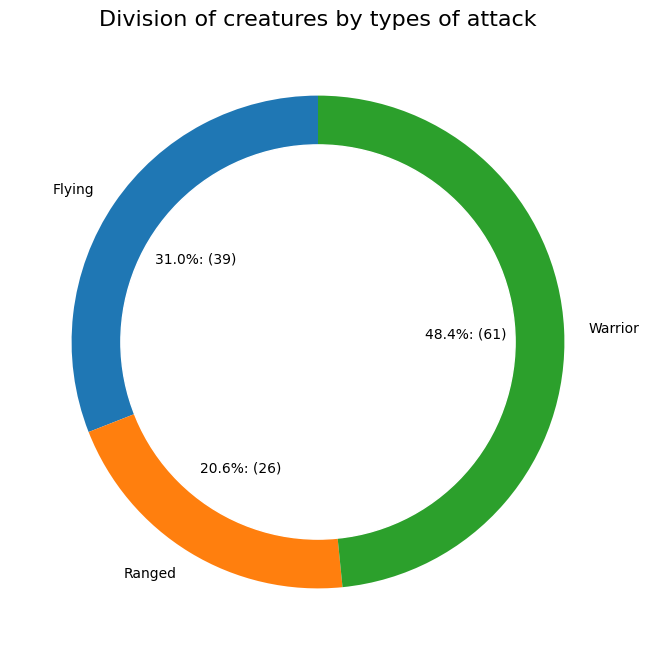

In [16]:
df = fractions.copy()
df['counter'] = 1
df_types = df.groupby(['type'], as_index=False).count()
fig, axes = plt.subplots(1,1,figsize=(8,8))
axes.pie(x = df_types['counter'],
         labels = df_types['type'],
         startangle = 90,
         autopct = lambda perc: ('%.1f%s: (%d)' %(perc, '%', round(perc*sum(df_types['counter'])/100,0)))
         )

# Turn it into a donut
white_circle = plt.Circle((0,0), 0.80, color='#FFFFFF')
axes.add_artist(white_circle)
axes.set_title('Division of creatures by types of attack',fontsize = 16)
plt.show()

An overview of the types of creatures by towns :

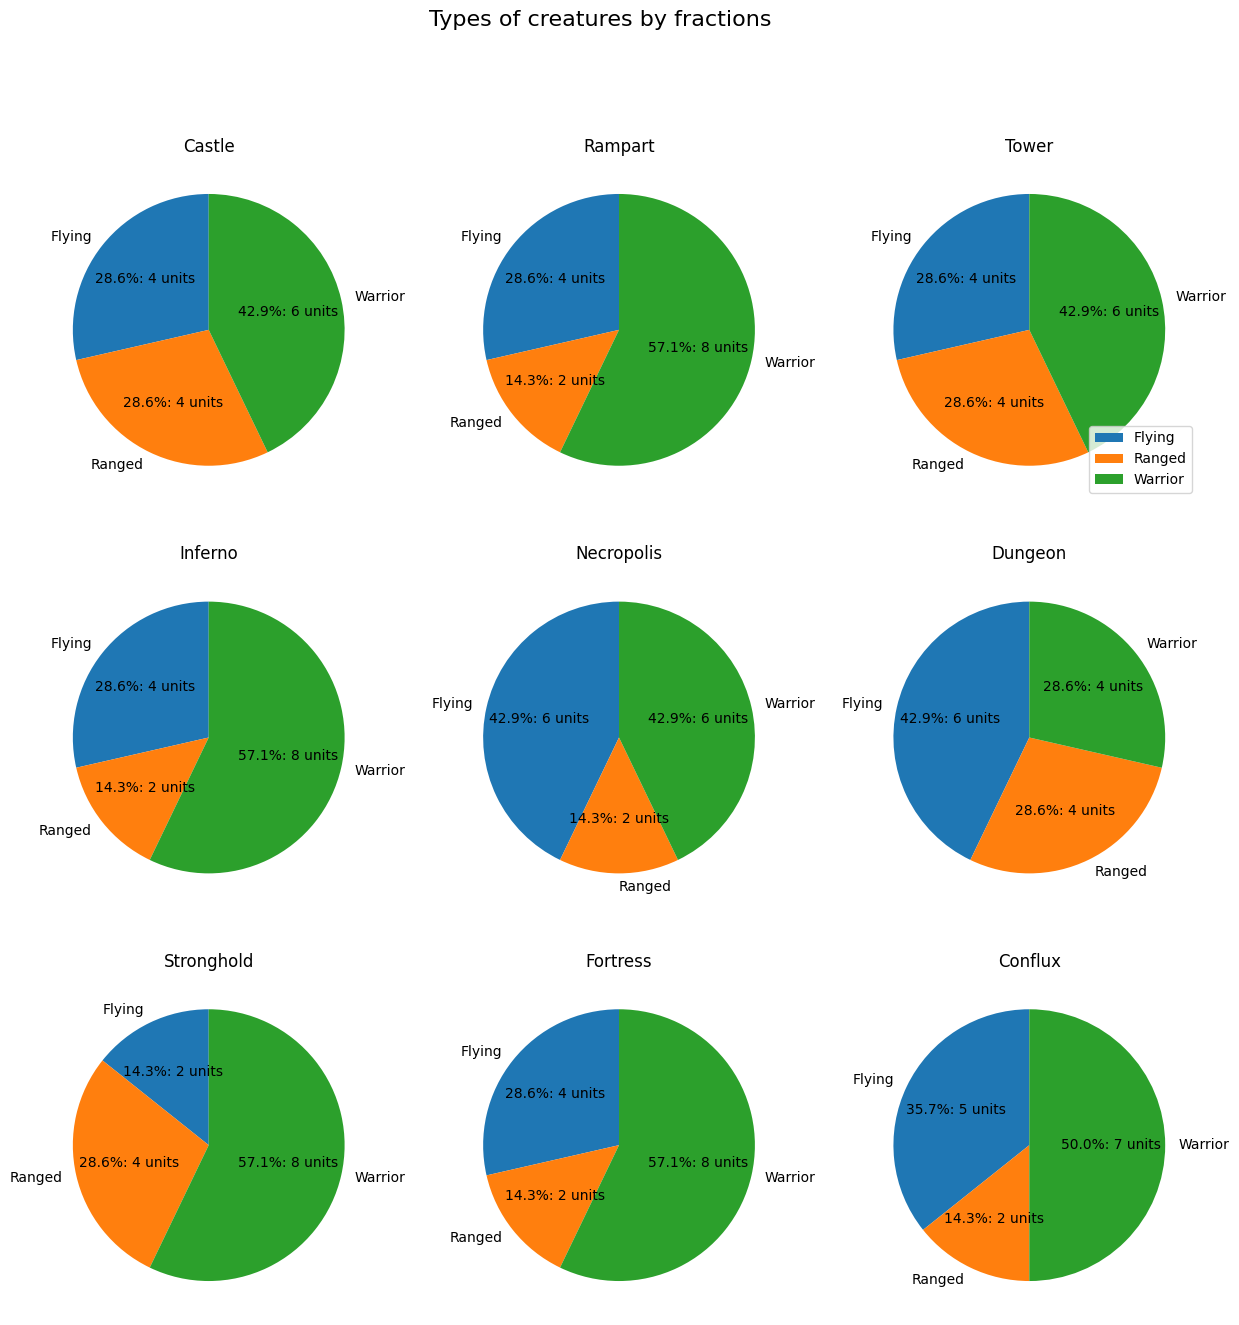

In [17]:
df_towns = df.groupby(['town', 'type'], as_index=False).count()

fig, axes = plt.subplots(3,3, figsize=(15,15))
towns = fractions['town'].unique()

# Print pie charts in a 3x3 matrix
for i in range(0, 3, 1):
    for j in range(0, 3, 1):
        adf = df_towns[df_towns['town'] == towns[i*3 + j]]
        fa = axes[i][j]
        fa.set_title(towns[i*3 + j])
        fa.pie(x = adf['counter'],
               labels = adf['type'],
               startangle = 90,
               autopct = lambda perc: ('%.1f%s: %d units' %(perc, '%', round(perc*sum(adf['counter'])/100,0)))
               )
        fa.axis('off')

axes[0][2].legend()
fig.suptitle('Types of creatures by fractions', fontsize = 16)
plt.show()

For non-upgraded creatures :

In [18]:
df = fractions[fractions.index % 2 == 0].copy()
df['cost_per_week'] = df['growth'] * df['gold']
df['ai_per_week']   = df['growth'] * df['ai_value']

df = df.groupby(['town'], as_index = False).sum()
df = df.drop(['att', 'def', 'min_dmg', 'max_dmg', 'hp', 'speed', 'growth', 'ai_value', 'gold'], axis = 1)
df

<ipython-input-18-f3141e19a3a0>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['town'], as_index = False).sum()


,town,cost_per_week,ai_per_week
0,Castle,10540,16857
1,Conflux,11650,20603
2,Dungeon,10390,16779
3,Fortress,10025,15648
4,Inferno,9750,16323
5,Necropolis,10210,15588
6,Rampart,9740,16767
7,Stronghold,8550,13853
8,Tower,9800,16371


A better display of the results from above :

Text(0, 0.5, 'Combined AI values and cost per week')

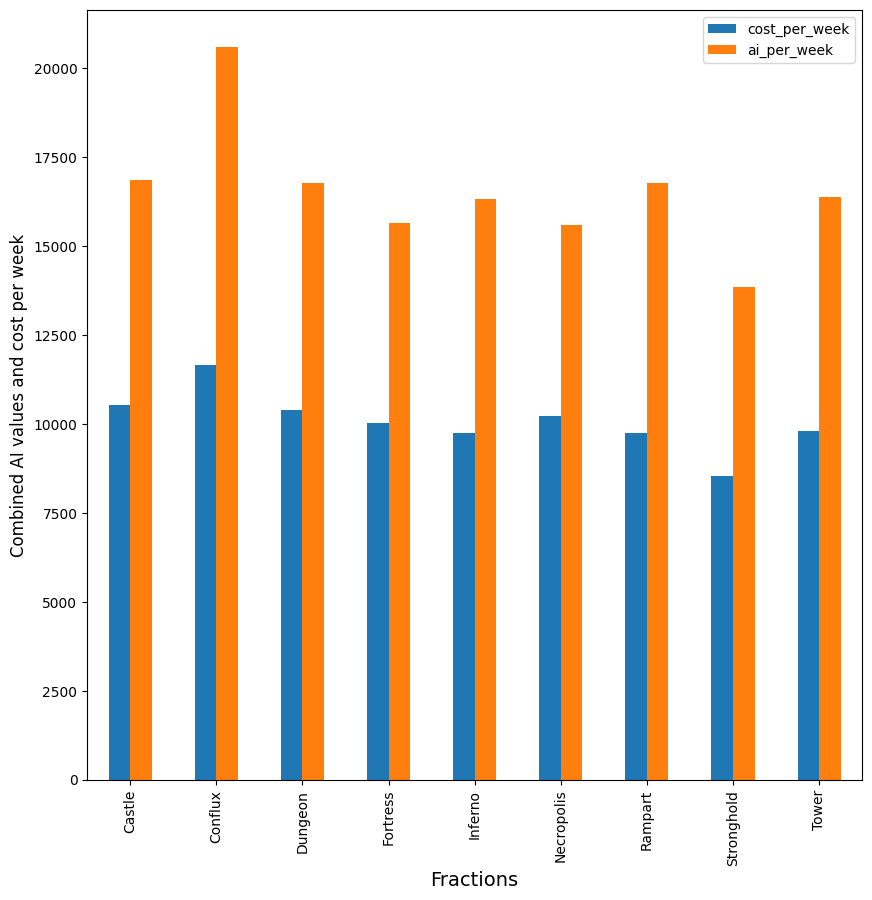

In [19]:
axes = df.plot.bar(x = 'town', subplots = False, figsize = (10,10))
plt.xlabel("Fractions", size = 14)
plt.ylabel("Combined AI values and cost per week", size = 12)

For upgraded creatures :

In [20]:
df = fractions[fractions.index % 2 == 1].copy()
df['cost_per_week'] = df['growth']*df['gold']
df['ai_per_week'] = df['growth']*df['ai_value']

df = df.groupby(['town'], as_index = False).sum()
df = df.drop(['att', 'def', 'min_dmg', 'max_dmg', 'hp', 'speed', 'growth', 'ai_value', 'gold'], axis = 1)
df

<ipython-input-20-ef6669502c13>:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df = df.groupby(['town'], as_index = False).sum()


,town,cost_per_week,ai_per_week
0,Castle,14430,23860
1,Conflux,14100,28872
2,Dungeon,13375,23060
3,Fortress,13120,19887
4,Inferno,13430,21183
5,Necropolis,13250,20078
6,Rampart,12585,23663
7,Stronghold,12065,19737
8,Tower,15080,24063


A better display of the results from above :

Text(0, 0.5, 'Combined AI values and cost per week')

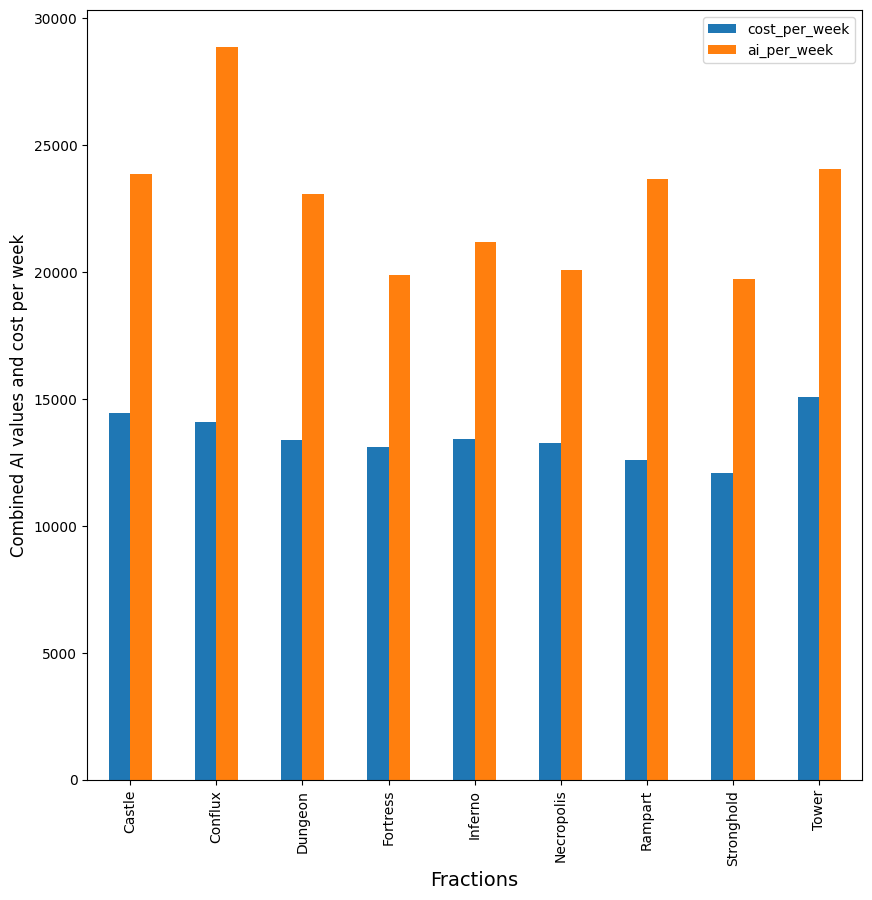

In [21]:
axes = df.plot.bar(x = 'town', subplots = False, figsize = (10,10))
plt.xlabel("Fractions", size = 14)
plt.ylabel("Combined AI values and cost per week", size = 12)

We can see that ***'cost'*** and ***'ai_value'*** have somewhat similar behaviour, but not similar enough to suspect a linear connection between them. Also ***'cost'*** is much more volatile (bigger standard deviation).

Lets take a closer look at the parameters and how they may affect the ai_value:
 - **"gold"** represents the cost of a creature. It surely is strongly correlated to the same parameters that form the **"ai_value"**, but cost means nothing on the battlefield.
 - **"resources"** gives no idea about a unit as it has no value for most units. It is part of the cost to add difficulty to the game and increase the need for good map management.
 - **"growth"** (shows how many creatures can be bought each 'normal' week) is a non-battle parameter that should not be included as it has nothing to do with the AI_Value. However this idea should be supported by some numbers, so to put things into perspective, a diagram of correlations will be presented below.

There is no logical explanation to remove any other parameter for now.

**Tip:** <i> If the correlation is low (between -0.5 and 0.5), its would be best to be disregarded, but not every high one (such as **"Gold"** to **"AI_value"**) is worth paying attention to.</i>

Lets see a full (only numeric parameters included) correlation table :

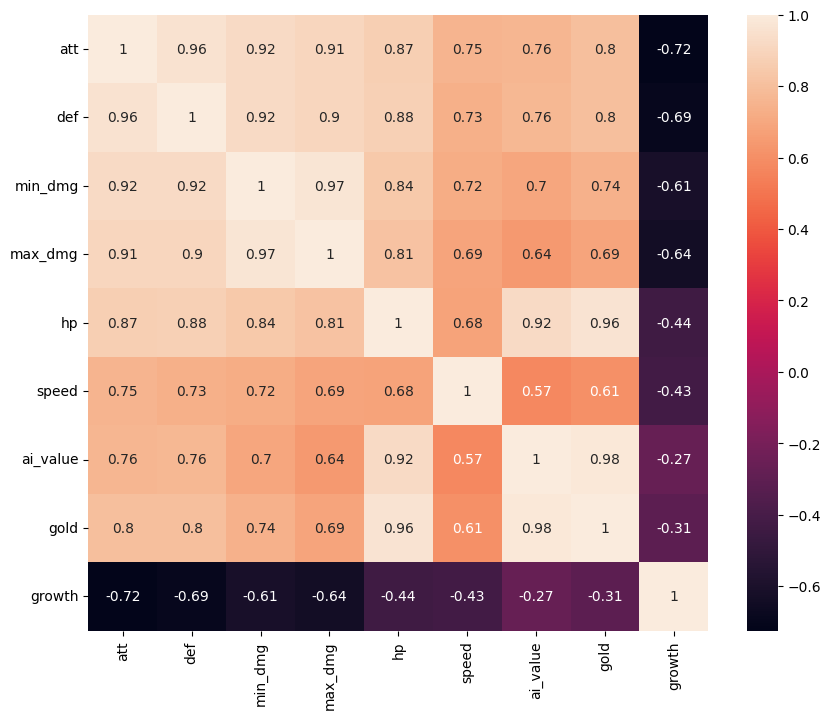

In [22]:
creatures = units[['att', 'def', 'min_dmg', 'max_dmg', 'hp',
                           'speed', 'ai_value', 'gold','growth']]
correlations = creatures.corr()
sns.heatmap(correlations, annot = True)
plt.gcf().set_size_inches(10, 8)

As expected growth does not affect ***'gold'*** or ***'ai_value'*** or any of their (expected) parameters. Also we can clearly see the similarities in the way the other parameters correlate to both ***'gold'*** and ***'ai_value'*** (they have a constant difference of
0.04 - 0.05).

#### **Hypothesis 1 confirmed!**

Now lets delve into ***ai_value***.

Following the idea mentioned in **Tip**, the final look of the diagram is :

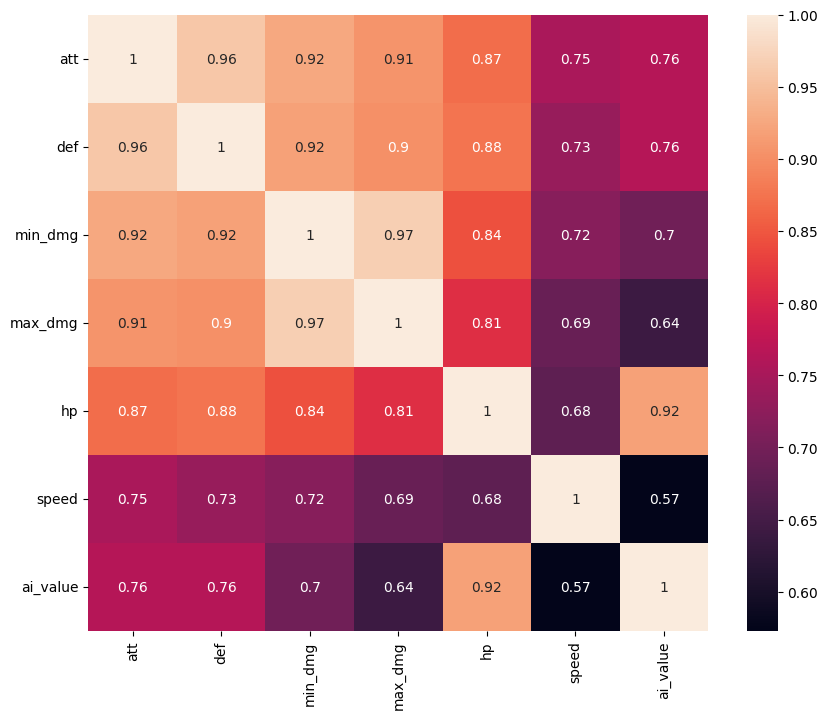

In [23]:
creatures = creatures[['att', 'def', 'min_dmg', 'max_dmg', 'hp', 'speed', 'ai_value']]
correlations = creatures.corr()
sns.heatmap(correlations, annot=True)
plt.gcf().set_size_inches(10, 8)

Paying attention to **"ai_value"**, we can see that **"att"** (Attack) and **"def"** (Defense) have the same high correlation, **"hp"**(Health) seems to be of the greatest importance and **"speed"** seems to be at the bottom of the list. Lets take a closer look at the parameters in the table. Have in mind that a little bit of noise in the data is needed so the game could offer diversity and different strategies, which probably makes the initial task even harder.

<Figure size 1200x1000 with 0 Axes>

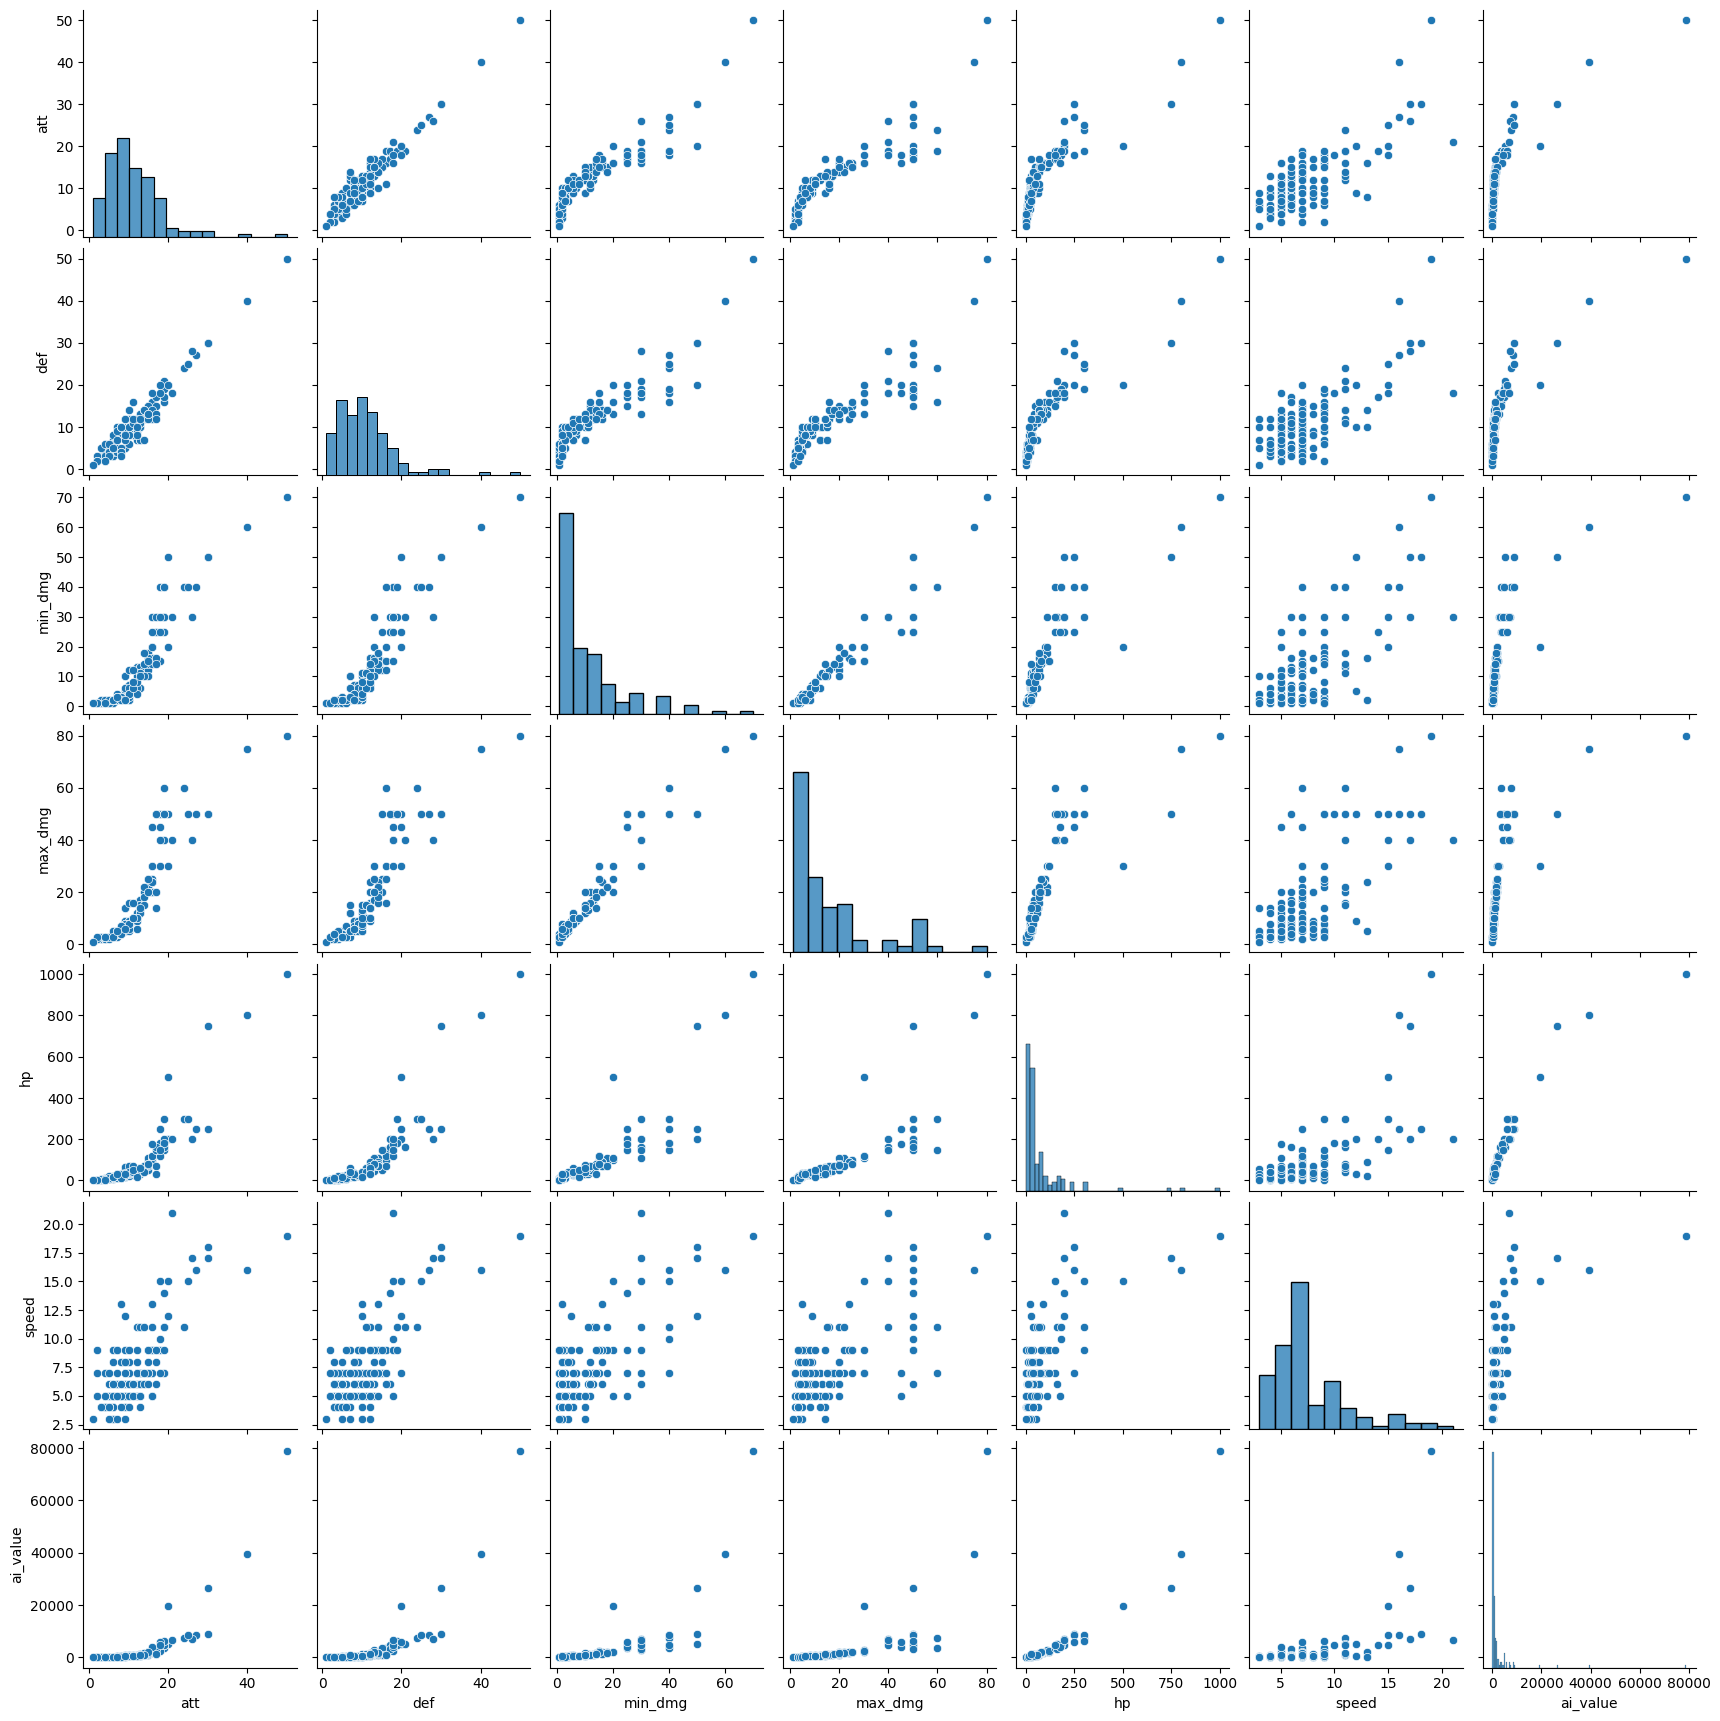

In [24]:
plt.figure(figsize = (12,10))

sns.pairplot(creatures[['att', 'def', 'min_dmg', 'max_dmg', 'hp', 'speed', 'ai_value']])

Seems like ***'speed'*** has more noise in comparisson to all other parameters, as if it plays close to none role in the forming of ***'ai_value'***. It has a very scattered plot which means a big standard deviation. However, this parameter could be of great importance on the battlefield. Different values for speed may be applied based on the type of creature (warrior, ranged, flying).

#### **Hypothesis 3 : Creature type affects <i>'ai_value'</i> (respectively cost as well).**

***Type*** is mentioned in the field of ***abilites*** and as said earlier, its possible that this field plays a role in modelling. Also the upper rightmost points (those with the highest values in all paramteres) represent the strongest creatures - levels ***'7'*** and ***'7+'***. We may want to seperate them as they look a bit like outliers and check if its benefits the model. However reducing the data more, when there are less than 200 rows is a risky move. Such an action should be well considered. Lets take a closer look at the graphs above.

Top parameter from the correlation map above :

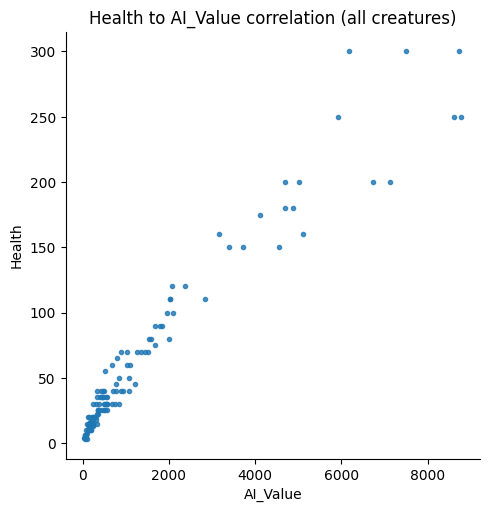

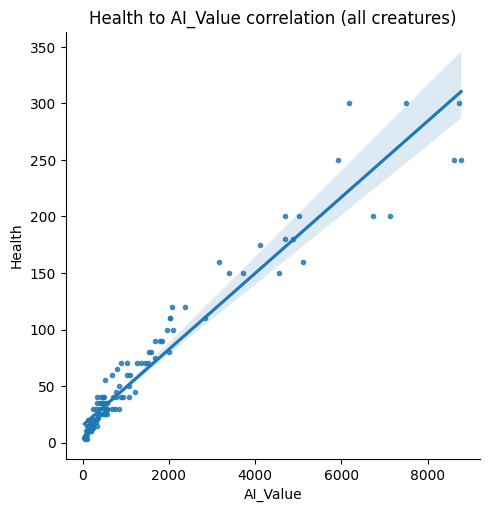

In [25]:
sns.lmplot(x='ai_value', y='hp', data = fractions, markers = '.', fit_reg = False)
plt.title('Health to AI_Value correlation (all creatures)')
plt.xlabel('AI_Value')
plt.ylabel('Health')
plt.show()

print()

sns.lmplot(x='ai_value', y='hp', data = fractions, markers = '.', fit_reg = True)
plt.title('Health to AI_Value correlation (all creatures)')
plt.xlabel('AI_Value')
plt.ylabel('Health')
plt.show()

Points after Health ~ 150 may be act like outliers. Lets take a look at which these creatures are :

In [26]:
fractions[fractions.hp >= 150]

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
12,Angel,Castle,Flying,7,20,20,50,50,200,12,1,5019,3000,"Gem,1","Flying,HatesDevils,Morale+1"
13,Archangel,Castle,Flying,7+,30,30,50,50,250,18,1,8776,5000,"Gem,3","Flying,HatesDevils,Resurrection,Morale+1"
26,GreenDragon,Rampart,Flying,7,18,18,40,50,180,10,1,4872,2400,"Crystal,1","Flying,Breathattack,Resistlvl1–3spells"
27,GoldDragon,Rampart,Flying,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
40,Giant,Tower,Warrior,7,19,16,40,60,150,7,1,3718,2000,"Gem,1",ImmunitytoMind
41,Titan,Tower,Ranged,7+,24,24,40,60,300,11,1,7500,5000,"Gem,2","Ranged(24shots),Nomeleepenalty,ImmunitytoMind,..."
54,Devil,Inferno,Flying,7,19,21,30,40,160,11,1,5101,2700,"Mercury,1","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
55,ArchDevil,Inferno,Flying,7+,26,28,30,40,200,17,1,7115,4500,"Mercury,2","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
68,BoneDragon,Necropolis,Flying,7,17,15,25,50,150,9,1,3388,1800,0,"Dragon,Undead,Flying,Morale-1"
69,GhostDragon,Necropolis,Flying,7+,19,17,25,50,200,14,1,4696,3000,"Mercury,1","Dragon,Undead,Flying,Morale-1,Aging"


In [27]:
fractions[fractions.hp >= 150].level.unique()

array(['7', '7+'], dtype=object)

Lets take a look at how the parameters in the second place from the 'heat map', are related to each other :

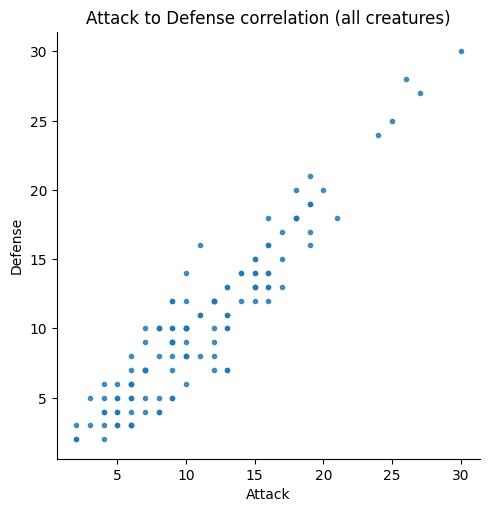

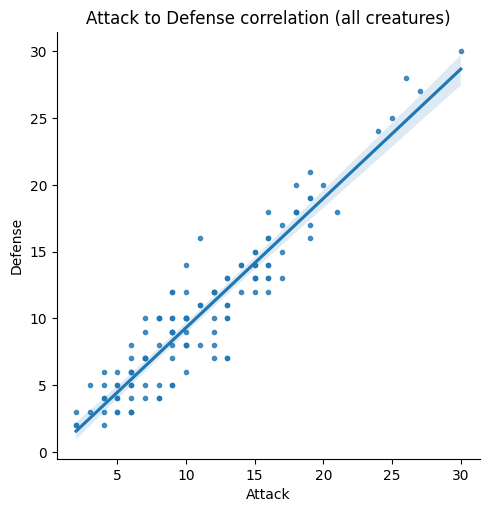

In [28]:
sns.lmplot(x='att', y='def', data = fractions, markers = '.', fit_reg = False)
plt.title('Attack to Defense correlation (all creatures)')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.show()

print()

sns.lmplot(x='att', y='def', data = fractions, markers = '.', fit_reg = True)
plt.title('Attack to Defense correlation (all creatures)')
plt.xlabel('Attack')
plt.ylabel('Defense')
plt.show()

This 'balanced' behaviour represents the close correlation of both of the parameters to **"ai_value"** and **"gold"**.

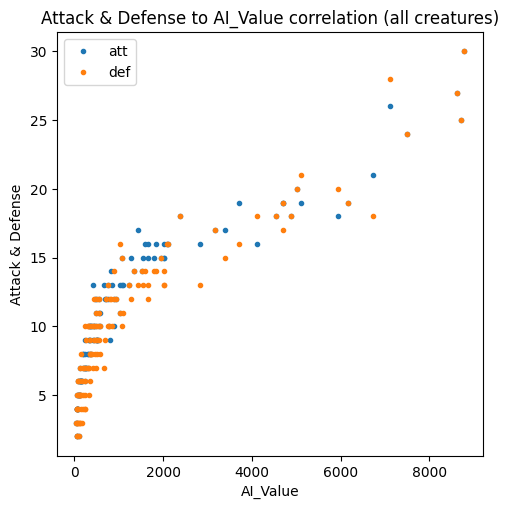

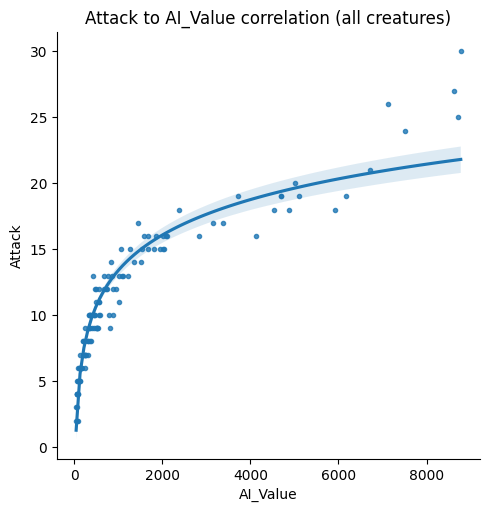

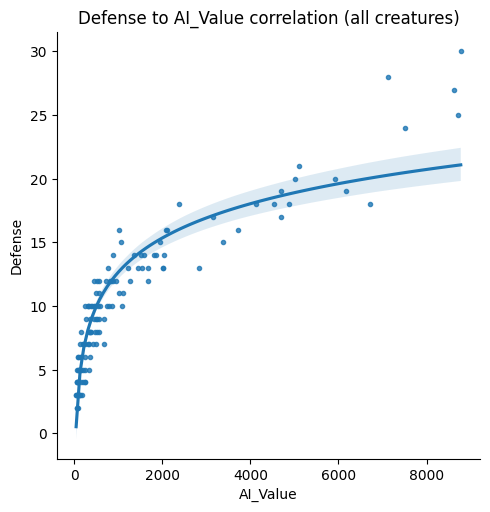

In [29]:
fractions.plot(x='ai_value', y=['att', 'def'], style='.', figsize=(5.5,5.5))
plt.title('Attack & Defense to AI_Value correlation (all creatures)')
plt.xlabel('AI_Value')
plt.ylabel('Attack & Defense')
plt.show()

print()

sns.lmplot(x = 'ai_value', y = 'att', data = fractions, markers = '.', logx = True)
plt.title('Attack to AI_Value correlation (all creatures)')
plt.xlabel('AI_Value')
plt.ylabel('Attack')
plt.show()

print()

sns.lmplot(x = 'ai_value', y = 'def', data = fractions, markers = '.', logx = True)
plt.title('Defense to AI_Value correlation (all creatures)')
plt.xlabel('AI_Value')
plt.ylabel('Defense')
plt.show()

Seems like the either points with Attack & Defense >= 20 hint for a polynome of frank 3 or they act as outliers.

In [30]:
fractions[fractions.att >= 20]

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
12,Angel,Castle,Flying,7,20,20,50,50,200,12,1,5019,3000,"Gem,1","Flying,HatesDevils,Morale+1"
13,Archangel,Castle,Flying,7+,30,30,50,50,250,18,1,8776,5000,"Gem,3","Flying,HatesDevils,Resurrection,Morale+1"
27,GoldDragon,Rampart,Flying,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
41,Titan,Tower,Ranged,7+,24,24,40,60,300,11,1,7500,5000,"Gem,2","Ranged(24shots),Nomeleepenalty,ImmunitytoMind,..."
55,ArchDevil,Inferno,Flying,7+,26,28,30,40,200,17,1,7115,4500,"Mercury,2","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
83,BlackDragon,Dungeon,Flying,7+,25,25,40,50,300,15,1,8721,4000,"Sulfur,2","Dragon,Flying,Breathattack,Resistallspells,Hat..."
125,Phoenix,Conflux,Flying,7+,21,18,30,40,200,21,2,6721,2000,"Mercury,1","Flying,Breathattack,Fireimmunity,Rebirth"


In [31]:
fractions[fractions.att >= 20].level.unique()

array(['7', '7+'], dtype=object)

In third place from the 'heat map' comes the damage:

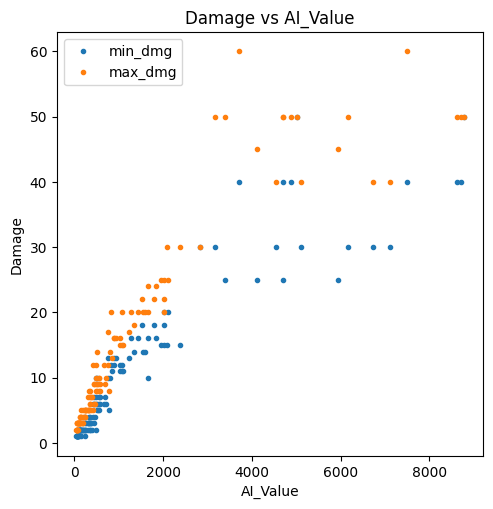

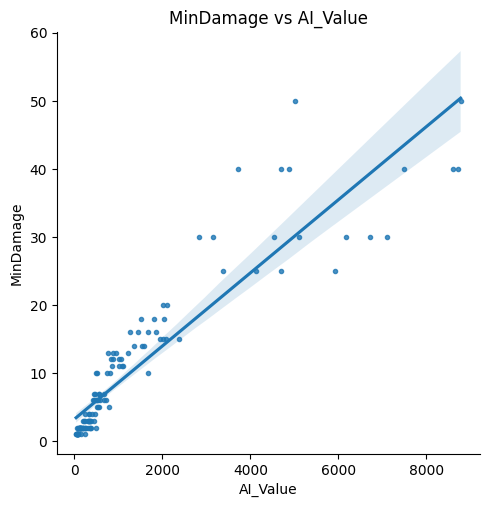

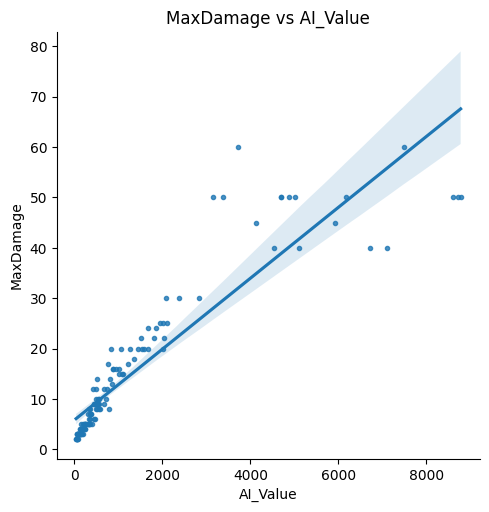

In [32]:
fractions.plot(x='ai_value', y=['min_dmg', 'max_dmg'], style='.', figsize=(5.5,5.5))
plt.title('Damage vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('Damage')
plt.show()

print()

sns.lmplot(x = 'ai_value', y = 'min_dmg', data = fractions, markers = '.', fit_reg = True)
plt.title('MinDamage vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('MinDamage')
plt.show()

print()

sns.lmplot(x = 'ai_value', y = 'max_dmg', data = fractions, markers = '.', fit_reg = True)
plt.title('MaxDamage vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('MaxDamage')
plt.show()

Looks like after Damage ~ 25 the model changes its behaviour - from almost linear to logarithmic/polynomial and becomes noisy. Lets have a look at the those problematic points.

In [33]:
fractions[fractions.max_dmg >= 25]

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
10,Cavalier,Castle,Warrior,6,15,15,15,25,100,7,2,1946,1000,0,Jousting
11,Champion,Castle,Warrior,6+,16,16,20,25,100,9,2,2100,1200,0,Jousting
12,Angel,Castle,Flying,7,20,20,50,50,200,12,1,5019,3000,"Gem,1","Flying,HatesDevils,Morale+1"
13,Archangel,Castle,Flying,7+,30,30,50,50,250,18,1,8776,5000,"Gem,3","Flying,HatesDevils,Resurrection,Morale+1"
26,GreenDragon,Rampart,Flying,7,18,18,40,50,180,10,1,4872,2400,"Crystal,1","Flying,Breathattack,Resistlvl1–3spells"
27,GoldDragon,Rampart,Flying,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
39,NagaQueen,Tower,Warrior,6+,16,13,30,30,110,7,2,2840,1600,0,Noenemyretaliation
40,Giant,Tower,Warrior,7,19,16,40,60,150,7,1,3718,2000,"Gem,1",ImmunitytoMind
41,Titan,Tower,Ranged,7+,24,24,40,60,300,11,1,7500,5000,"Gem,2","Ranged(24shots),Nomeleepenalty,ImmunitytoMind,..."
54,Devil,Inferno,Flying,7,19,21,30,40,160,11,1,5101,2700,"Mercury,1","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"


In [34]:
fractions[fractions.max_dmg >= 25].level.unique()

array(['6', '6+', '7', '7+'], dtype=object)

Now lets see what the behaviour of least correlated feature from the 'heat map' :

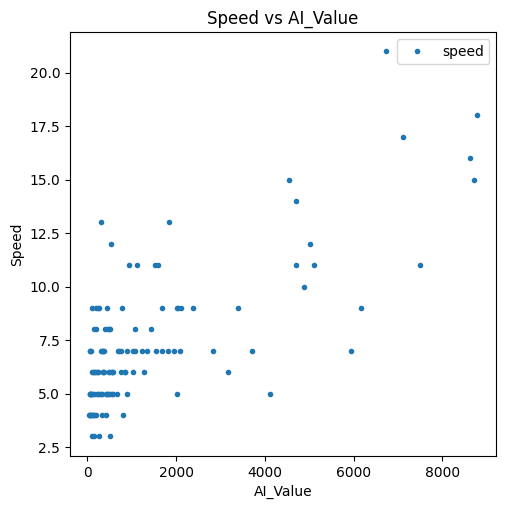

In [35]:
fractions.plot(x='ai_value', y='speed', style='.', figsize=(5.5,5.5))
plt.title('Speed vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('Speed')
plt.show()

This far the scatterplots showed values that could be modeled, but in this particular plot it seems the noise is too much.

Earlier we specified types of creatures. Flying and teleporting creature tend to be the fastest, so lets separate and conquer.

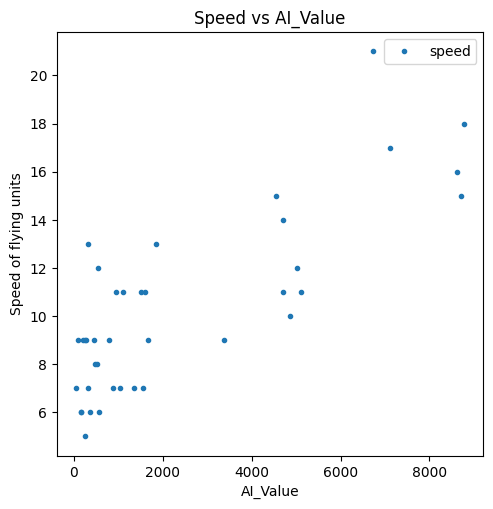

In [36]:
fractions[fractions.type == 'Flying'].plot(x='ai_value', y='speed', style='.', figsize=(5.5,5.5))
plt.title('Speed vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('Speed of flying units')
plt.show()

Data seems noisy.

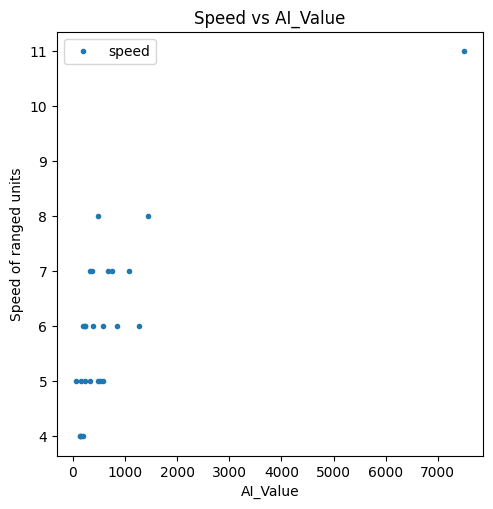

In [37]:
fractions[fractions.type == 'Ranged'].plot(x='ai_value', y='speed', style='.', figsize=(5.5,5.5))
plt.title('Speed vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('Speed of ranged units')
plt.show()

Looks better.

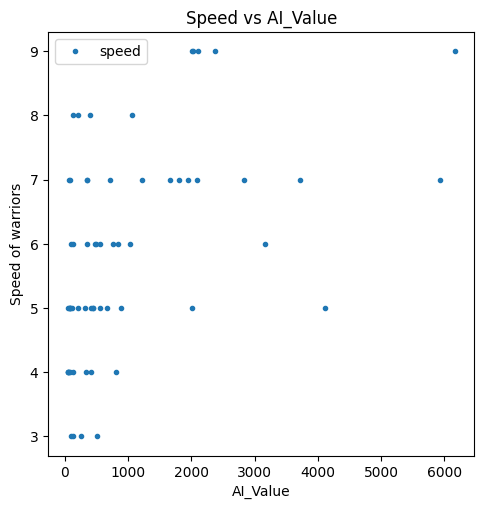

In [38]:
fractions[fractions.type == 'Warrior'].plot(x='ai_value', y='speed', style='.', figsize=(5.5,5.5))
plt.title('Speed vs AI_Value')
plt.xlabel('AI_Value')
plt.ylabel('Speed of warriors')
plt.show()

Doesn't sooth the eye.

All three plots show data that contains both noise and outliers. As said earlier noise could be a good addition for the gameplay. However outliers will make modeling tough. In all cases such were found after AI_Value ~ 3000. Lets see which are this creatures :

In [39]:
fractions[fractions.ai_value >= 3000]

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
12,Angel,Castle,Flying,7,20,20,50,50,200,12,1,5019,3000,"Gem,1","Flying,HatesDevils,Morale+1"
13,Archangel,Castle,Flying,7+,30,30,50,50,250,18,1,8776,5000,"Gem,3","Flying,HatesDevils,Resurrection,Morale+1"
26,GreenDragon,Rampart,Flying,7,18,18,40,50,180,10,1,4872,2400,"Crystal,1","Flying,Breathattack,Resistlvl1–3spells"
27,GoldDragon,Rampart,Flying,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
40,Giant,Tower,Warrior,7,19,16,40,60,150,7,1,3718,2000,"Gem,1",ImmunitytoMind
41,Titan,Tower,Ranged,7+,24,24,40,60,300,11,1,7500,5000,"Gem,2","Ranged(24shots),Nomeleepenalty,ImmunitytoMind,..."
54,Devil,Inferno,Flying,7,19,21,30,40,160,11,1,5101,2700,"Mercury,1","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
55,ArchDevil,Inferno,Flying,7+,26,28,30,40,200,17,1,7115,4500,"Mercury,2","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
68,BoneDragon,Necropolis,Flying,7,17,15,25,50,150,9,1,3388,1800,0,"Dragon,Undead,Flying,Morale-1"
69,GhostDragon,Necropolis,Flying,7+,19,17,25,50,200,14,1,4696,3000,"Mercury,1","Dragon,Undead,Flying,Morale-1,Aging"


In [40]:
fractions[fractions.ai_value >= 3000].level.unique()

array(['7', '7+'], dtype=object)

Those few examples showed that there is a greater diversity in data above levels ***'6'*** and ***'6+'***. It seems reasonable to treat them as outliers. Once the data looks a bit more concise, it would be easier to model it and seek for a formula. Afterwards another model with all the creatures may be built for comparison. This will prove **Hypothesis 2**.

An overview of how each parameter goes along the creature army from a town. 'Castle' town given as example :

<i>Remember : higher level -> stronger creature -> higher **ai_value** and cost</i>

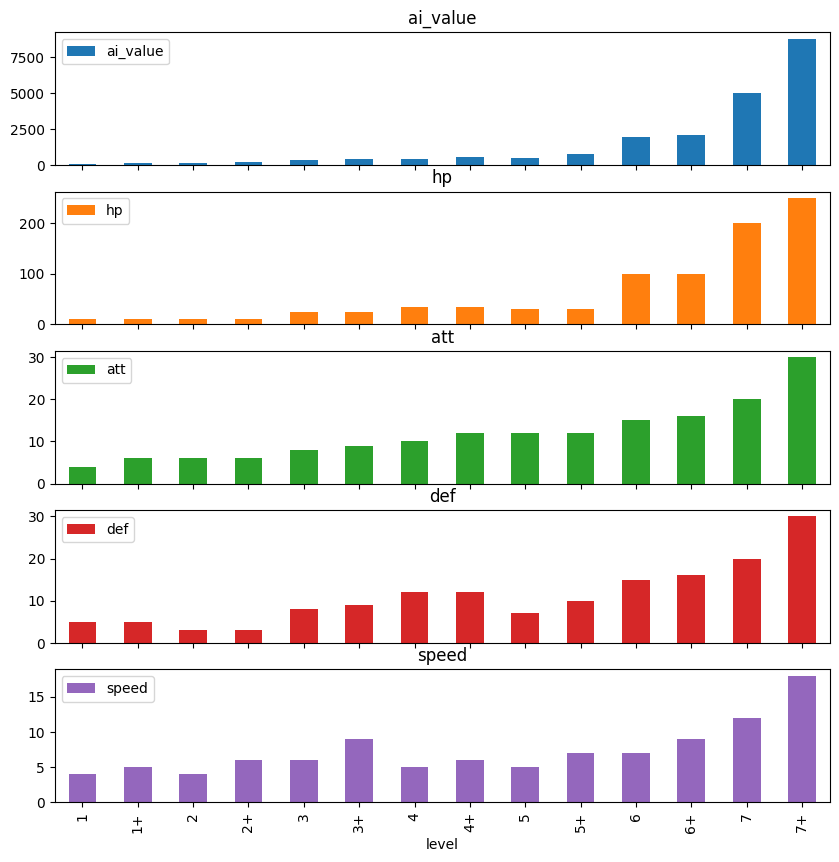

In [41]:
df = fractions[['town','level', 'ai_value', 'hp', 'att', 'def','speed']]
axes = df[df.town == 'Castle'].plot.bar(x = 'level', subplots=True, figsize=(10,10))

It is safe to say that all level 7 (both upgraded and non-upgraded) creatures carry great part of the identity of a fraction. They have special abilities that are far superior to most of those from the lower levels. Such abilites could alter the battle and push towards a certain strategy. This might be the reason why they vary so much in every parameter forming the ***ai_value***. Suppose that the formula for all creatures in the game is only one, but aside from these parameters it is affected by the abilities as well.

It would be best to build models on different datasets and compare them. Those datasets should include :
- all creatures
- all creatures without level ***7*** and ***7+***
- only creatures with no special abilities

Lets take a look at the units below level ***7*** :

In [42]:
fractions_level_7 = fractions[fractions.level.str.contains('7')]
fractions_level_7

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
12,Angel,Castle,Flying,7,20,20,50,50,200,12,1,5019,3000,"Gem,1","Flying,HatesDevils,Morale+1"
13,Archangel,Castle,Flying,7+,30,30,50,50,250,18,1,8776,5000,"Gem,3","Flying,HatesDevils,Resurrection,Morale+1"
26,GreenDragon,Rampart,Flying,7,18,18,40,50,180,10,1,4872,2400,"Crystal,1","Flying,Breathattack,Resistlvl1–3spells"
27,GoldDragon,Rampart,Flying,7+,27,27,40,50,250,16,1,8613,4000,"Crystal,2","Flying,Breathattack,Resistlvl1–4spells"
40,Giant,Tower,Warrior,7,19,16,40,60,150,7,1,3718,2000,"Gem,1",ImmunitytoMind
41,Titan,Tower,Ranged,7+,24,24,40,60,300,11,1,7500,5000,"Gem,2","Ranged(24shots),Nomeleepenalty,ImmunitytoMind,..."
54,Devil,Inferno,Flying,7,19,21,30,40,160,11,1,5101,2700,"Mercury,1","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
55,ArchDevil,Inferno,Flying,7+,26,28,30,40,200,17,1,7115,4500,"Mercury,2","Teleporting,Noenemyretaliation,Luck-1,HatesAngels"
68,BoneDragon,Necropolis,Flying,7,17,15,25,50,150,9,1,3388,1800,0,"Dragon,Undead,Flying,Morale-1"
69,GhostDragon,Necropolis,Flying,7+,19,17,25,50,200,14,1,4696,3000,"Mercury,1","Dragon,Undead,Flying,Morale-1,Aging"


In [43]:
fractions_below_level_7 = fractions.drop(fractions_level_7.index)

# Fix the indexes
fractions_below_level_7 = fractions_below_level_7.reset_index(drop=False)
fractions_below_level_7

,index,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting
1,1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting
2,2,Archer,Castle,Ranged,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots)
3,3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack"
4,4,Griffin,Castle,Flying,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,119,EnergyElemental,Conflux,Flying,4+*,12,8,4,6,35,8,5,470,400,0,"Elemental,Flying,Icevulnerability,Fireimmunity..."
104,120,EarthElemental,Conflux,Warrior,5,10,10,4,8,40,4,4,330,400,0,"Elemental,MeteorShowervulnerability,Lightninga..."
105,121,MagmaElemental,Conflux,Warrior,5+*,11,11,6,10,40,6,4,490,500,0,"Elemental,MeteorShowervulnerability,Lightninga..."
106,122,PsychicElemental,Conflux,Warrior,6,15,13,10,20,75,7,2,1669,750,0,"Elemental,Noenemyretaliation,Attacksadjacenthexes"


Now, lets see the some plots without units of levels ***'7'*** and ***'7+'***.
Top parameters from the correlation map :

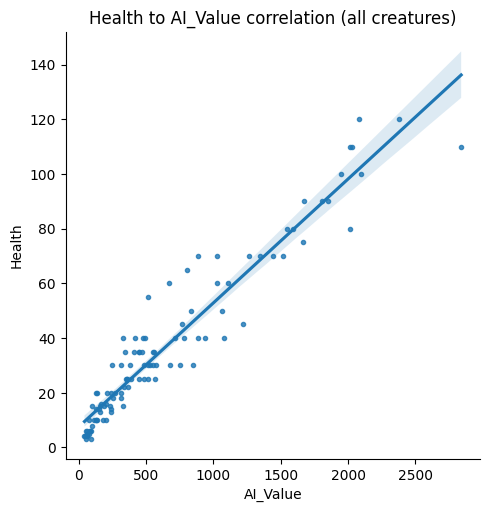

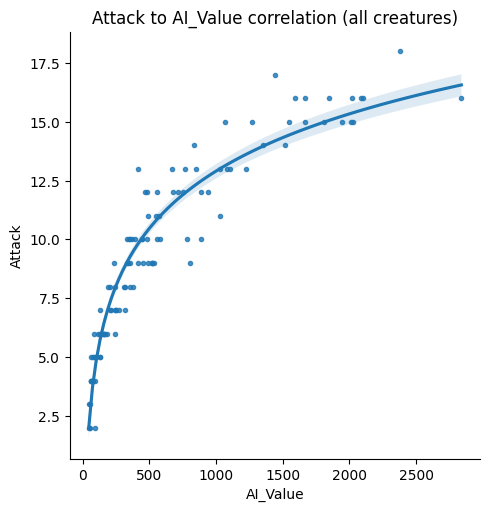

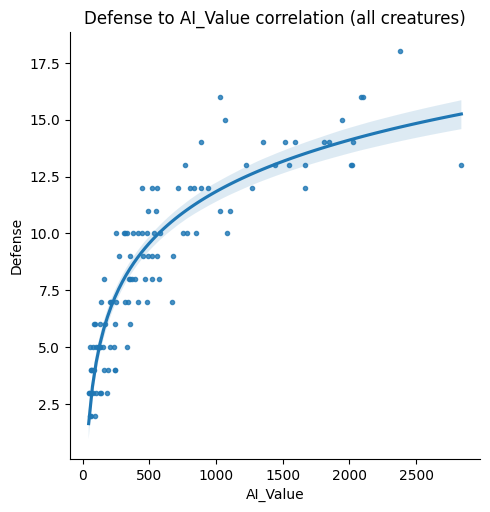

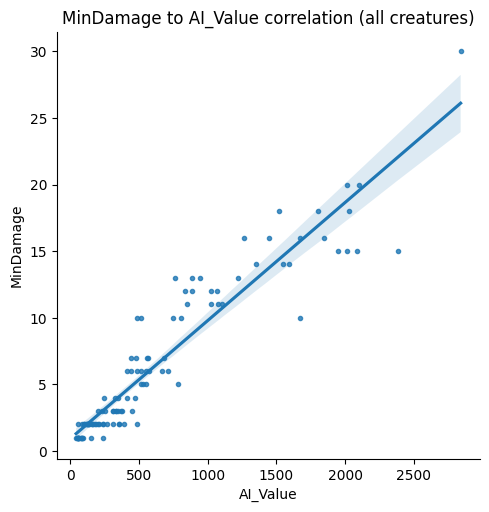

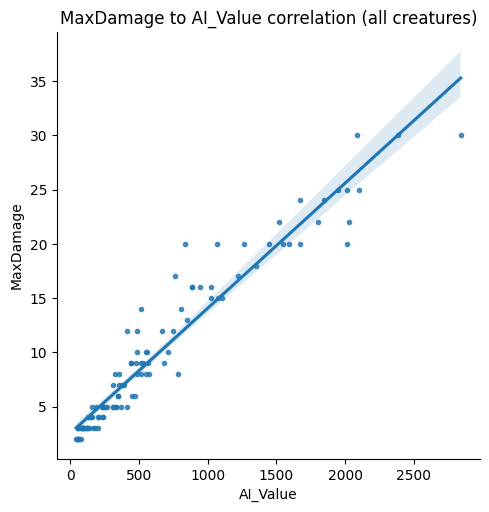

In [44]:
#                      Feature      Fit line (if False - fit logarithmic curve)
plots = {'hp'      : [ 'Health',    True ],
         'att'     : [ 'Attack',    False],
         'def'     : [ 'Defense',   False],
         'min_dmg' : [ 'MinDamage', True ],
         'max_dmg' : [ 'MaxDamage', True ]}

for key, value in plots.items():
    if value[1] :
        sns.lmplot(x='ai_value', y=key, data = fractions_below_level_7, markers = '.', fit_reg=True)
    else :
        sns.lmplot(x='ai_value', y=key, data = fractions_below_level_7, markers = '.', logx=True)
    plt.title(f'{value[0]} to AI_Value correlation (all creatures)')
    plt.xlabel('AI_Value')
    plt.ylabel(value[0])
    plt.show()
    print()

Last parameter (speed) from the correlation map by types :

================ Graphs for speed type : Warrior ================


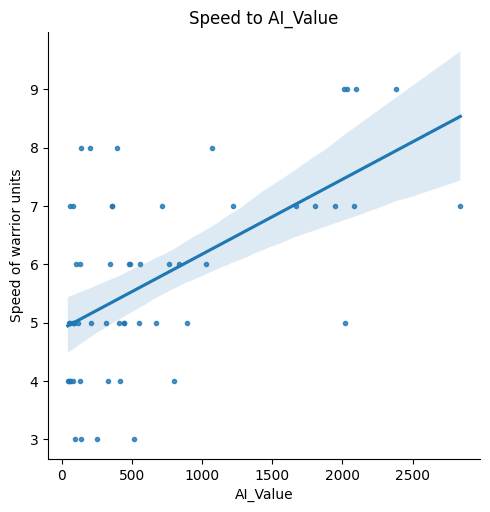

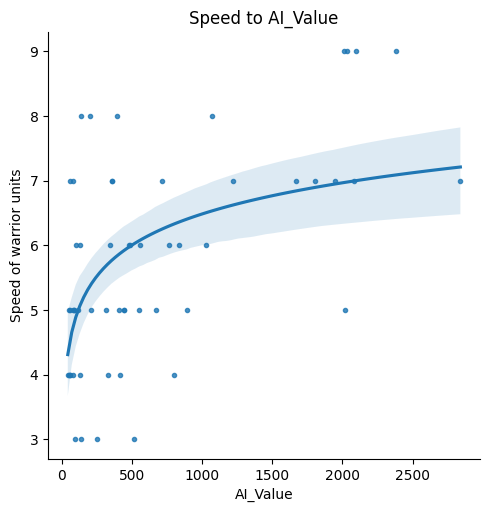


================ Graphs for speed type : Ranged ================


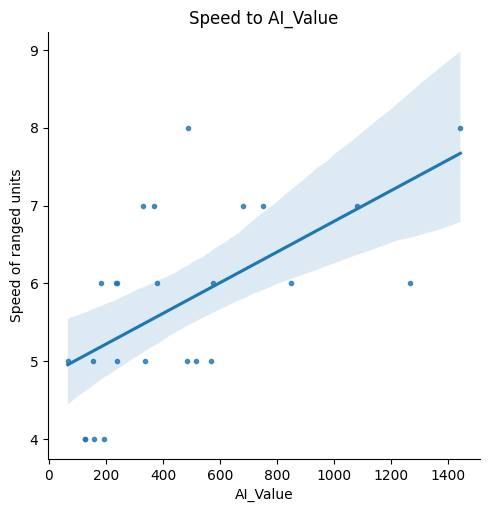

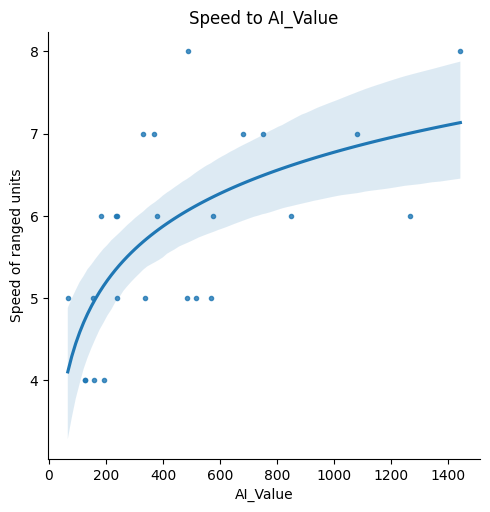


================ Graphs for speed type : Flying ================


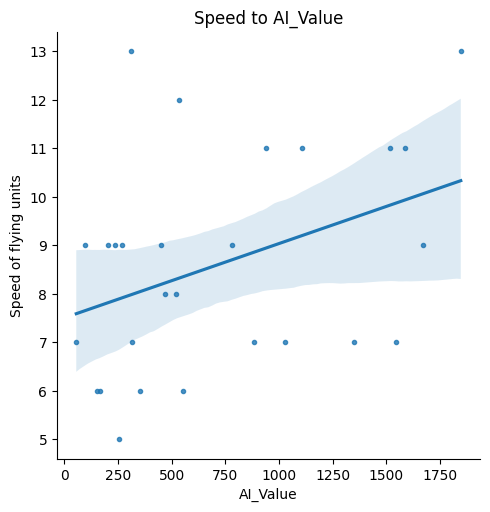

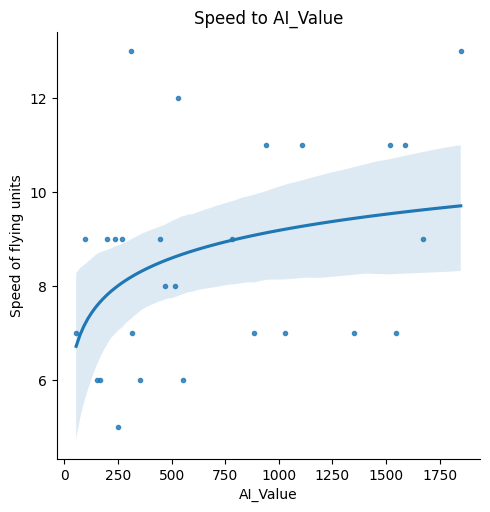

In [45]:
for unit_type in fractions_below_level_7.type.unique():
    print(f"================ Graphs for speed type : {unit_type} ================")
    sns.lmplot(x='ai_value', y='speed', data = fractions_below_level_7[fractions_below_level_7.type == unit_type], markers = '.', fit_reg = True)
    plt.title('Speed to AI_Value')
    plt.xlabel('AI_Value')
    plt.ylabel(f'Speed of {unit_type.lower()} units')
    plt.show()
    print()
    sns.lmplot(x='ai_value', y='speed', data = fractions_below_level_7[fractions_below_level_7.type == unit_type], markers = '.', logx = True)
    plt.title('Speed to AI_Value')
    plt.xlabel('AI_Value')
    plt.ylabel(f'Speed of {unit_type.lower()} units')
    plt.show()
    print()

The latter six plots look awful, compared to those above. They show great noise, so if they are part of the formula they would probably have a very small weight, compared to the other parameters.

The dataset excluding ***'7'*** and ***'7+'*** levels, all parameters (aside from speed) show somewhat evenly dispersed noise, which is probably there to bring diversity in the gameplay. This, however, points to an additional expectation - either there is no formula that could be derived and values have been set by the developers 'by hand' (and some common sense) or there is a precise formula and the noise seen above is due to the "abilities" of the units. Unfortunately there are just a few creatures that lack an ability (or have a negligible one). Building a model over them might bring some answers.

Plots of ***Health, MinDamage, MaxDamage*** showed strong linear behaviour whereas ***Attack*** and ***Defense*** had a non-linear one. They showed a curvature that resembled a logarithmic behaviour. Thus a little bit of a fix is needed in order to run a multiple linear regression on the data. Lets search for an approximate base of the supposedly used logarithmic or power function.

For a logarithmic function :

================= Graph with i set to: 2 =================


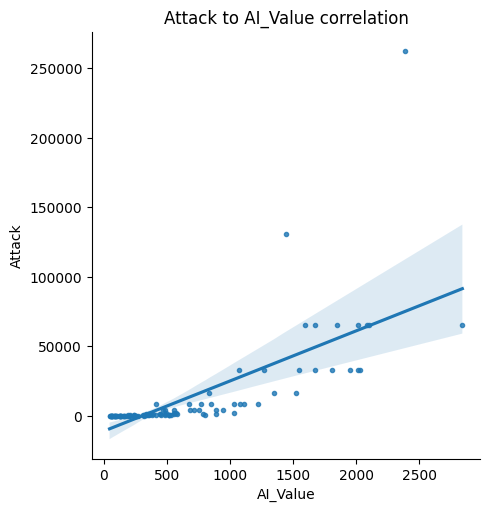

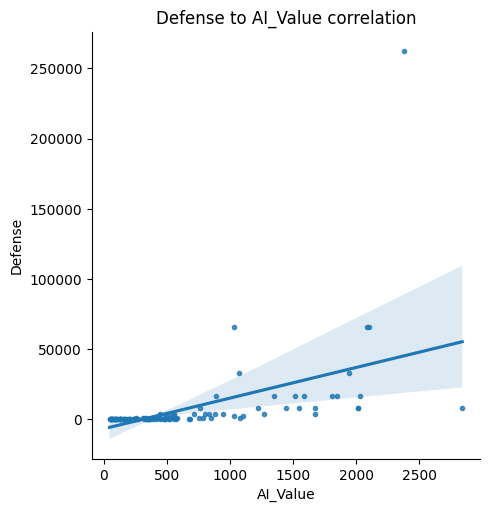


================= Graph with i set to: 3 =================


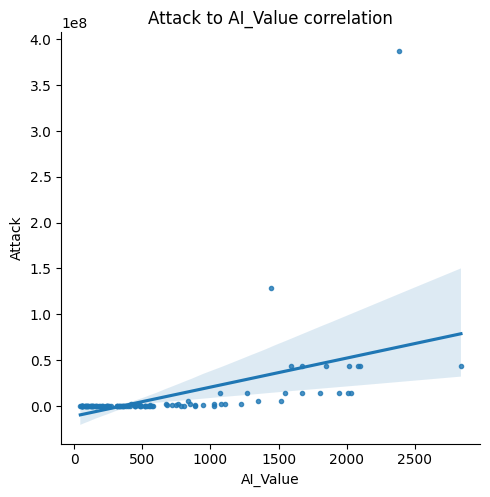

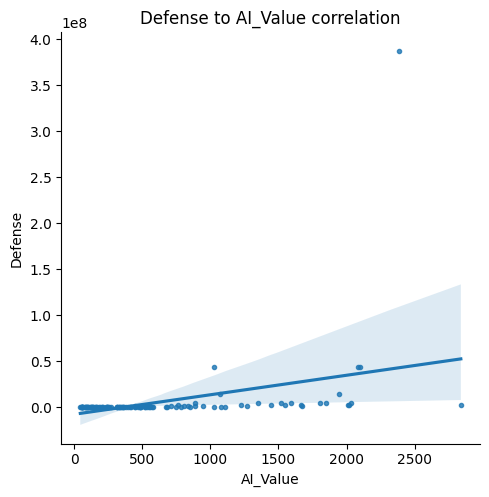


================= Graph with i set to: 4 =================


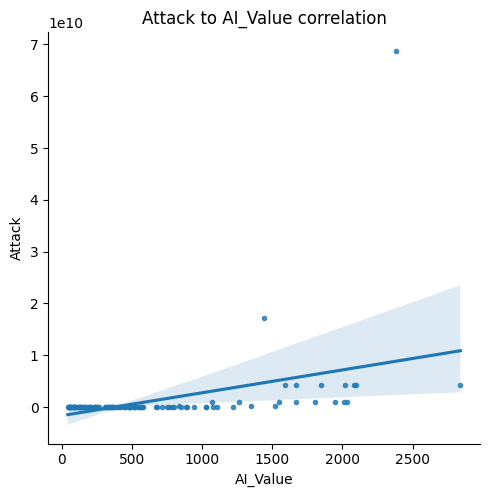

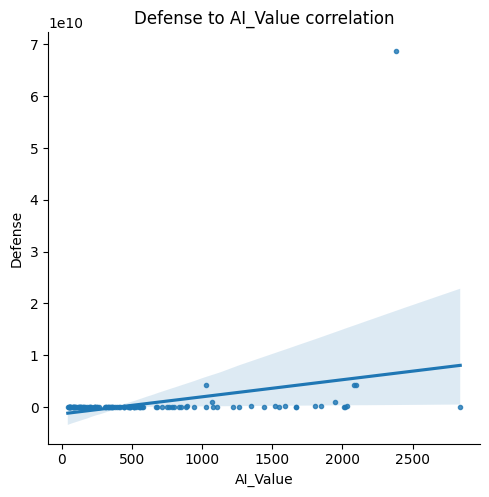

In [46]:
for i in range(2, 5):
    fractions_below_level_7['att_exp']=np.power(i, fractions_below_level_7['att'].values)
    fractions_below_level_7['def_exp']=np.power(i, fractions_below_level_7['def'].values)

    print(f"================= Graph with i set to: {i} =================")

    sns.lmplot(x = 'ai_value', y = 'att_exp', data = fractions_below_level_7, markers = '.', fit_reg = True)
    plt.title('Attack to AI_Value correlation')
    plt.xlabel('AI_Value')
    plt.ylabel('Attack')
    plt.show()

    print()

    sns.lmplot(x = 'ai_value', y = 'def_exp', data = fractions_below_level_7, markers = '.', fit_reg = True)
    plt.title('Defense to AI_Value correlation')
    plt.xlabel('AI_Value')
    plt.ylabel('Defense')
    plt.show()

    print()

For a power function :

================= Graph with i set to: 1 =================


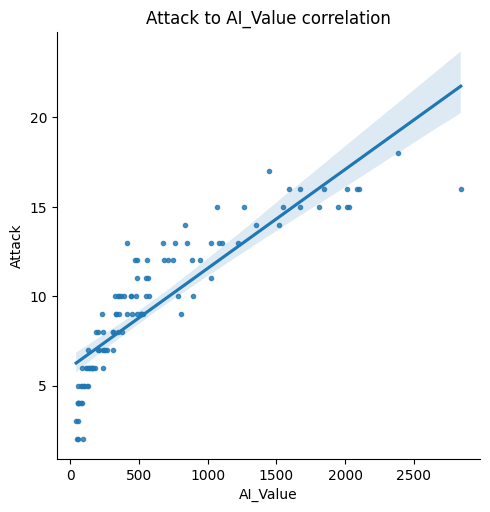

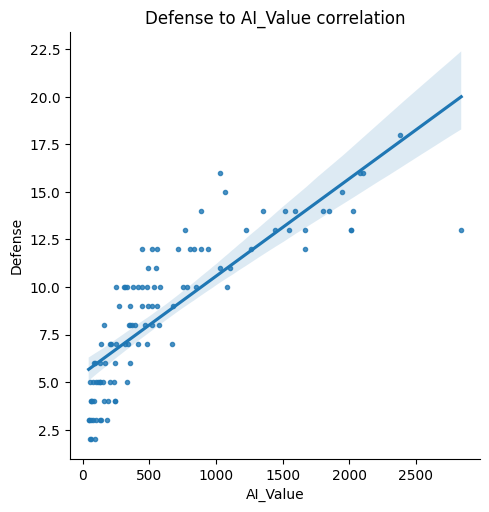


================= Graph with i set to: 2 =================


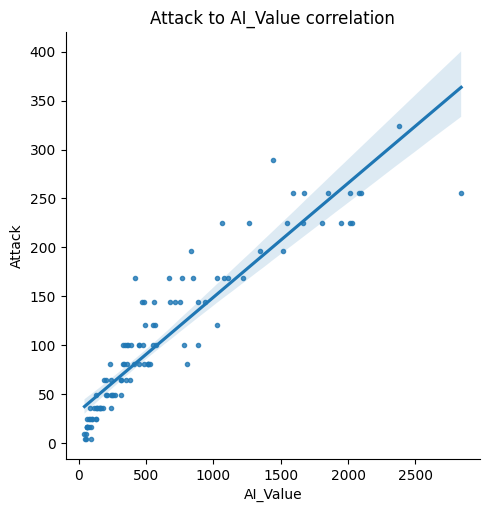

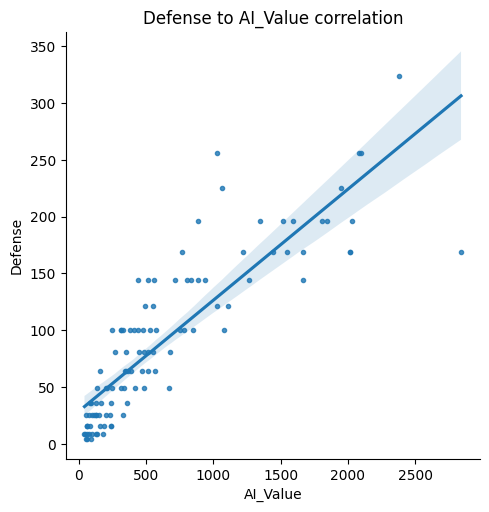


================= Graph with i set to: 3 =================


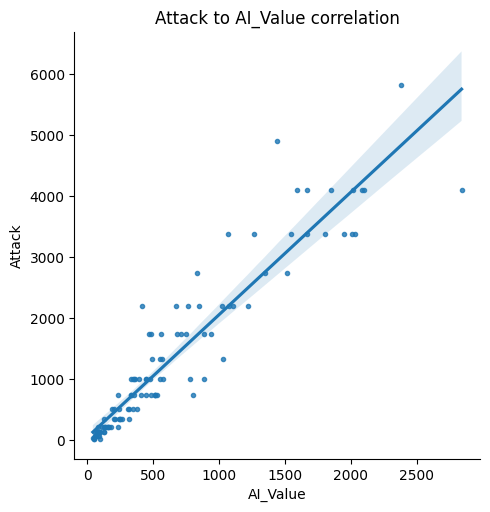

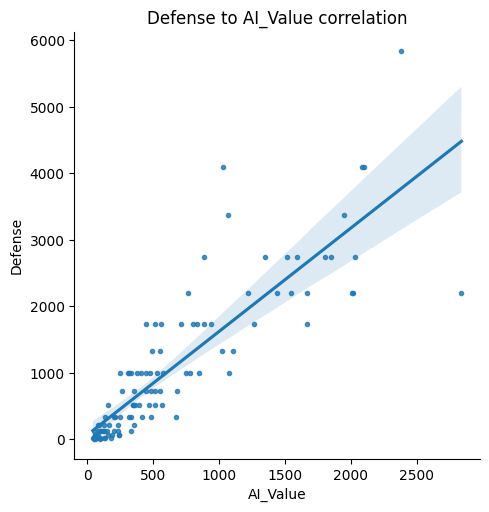


================= Graph with i set to: 4 =================


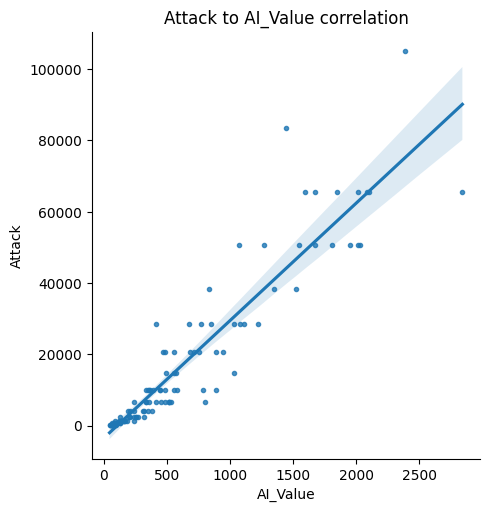

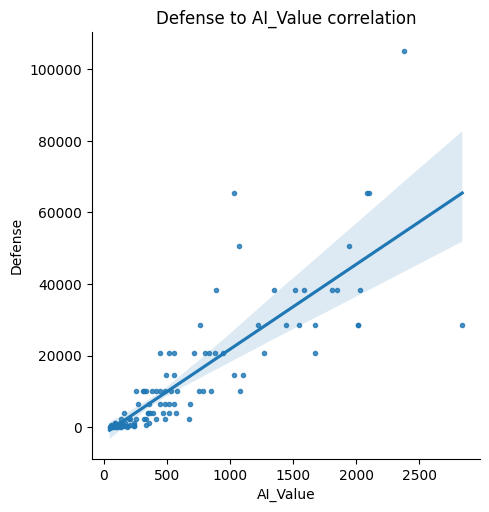

In [47]:
for i in range(1, 5):
    fractions_below_level_7['att_exp']=np.power(fractions_below_level_7['att'].values, i)
    fractions_below_level_7['def_exp']=np.power(fractions_below_level_7['def'].values, i)

    print(f"================= Graph with i set to: {i} =================")

    sns.lmplot(x = 'ai_value', y = 'att_exp', data = fractions_below_level_7, markers = '.', fit_reg = True)
    plt.title('Attack to AI_Value correlation')
    plt.xlabel('AI_Value')
    plt.ylabel('Attack')
    plt.show()

    print()

    sns.lmplot(x = 'ai_value', y = 'def_exp', data = fractions_below_level_7, markers = '.', fit_reg = True)
    plt.title('Defense to AI_Value correlation')
    plt.xlabel('AI_Value')
    plt.ylabel('Defense')
    plt.show()

    print()

Seems like a good fit for a linear behaviour would be achieved by a power function with a value of 3. This means that the function to fit the original data could look like this :

$$f(x) = a_{health}*x_{health} + a_{attack}*x_{attack}^{3} + a_{defense}*x_{defense}^{3} + a_{minDamage}*x_{minDamage} + a_{maxDamage}*x_{maxDamage} + a_{speed}*x_{speed} + b$$

The weights $$a_{attack},  a_{defense}$$ should be very small numbers compared to the other weights and probably have close if not the same value, given the similar values and behavior of $$x_{attack},  x_{defense}$$

The weights $$a_{minDamage},  a_{maxDamage}$$ whould probably have close if not the same value, given the similar values and behavior of $$x_{minDamage},  x_{maxDamage}$$

Lets prepare a functionality in the optimizer which adds penalty to the cost function in case those weights stray from each other. This would bring for some regularization of the data which could end up with negative result on the overall score. Thus the penalty should be optional.

### 4. Modelling phase
Lets build two models models - all units and all fractions bellow level 7. To reduce code repetition we need functions that :
- add new columns called ***att_exp*** and ***def_exp*** and print the resulting dataset
- scale the data
- seperate the variables from the target
- split the data
- fit a model
- score the model and show the coefficients and visualize the differences
- optimize the model and show its parameters

Keep in mind that the model should be 'centered', because there are no creatures with that could have **0** in any of their numerical stats - imagine a unit with 0 hp.

In [48]:
def add_transformed_data(dataset):
  dataset['att_exp']=np.power(dataset['att'].values, 3)
  dataset['def_exp']=np.power(dataset['def'].values, 3)

  return dataset

In [49]:
def scale_split_fit_score(dataset, scaler, model):
    variables = ['hp', 'att_exp', 'def_exp', 'min_dmg', 'max_dmg', 'speed']

    x = dataset[variables].values
    print(f"Shape of variables array : {x.shape}")
    y = dataset['ai_value'].values
    print(f"Shape of target vector : {y.shape}")
    print()

    scaler.fit(x)
    scaler.transform(x)

    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.10)

    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)

    print(f"Score on training data : {model.score(x_train, y_train)}")
    print(f"Score on testing data : {model.score(x_test, y_test)}")
    print()

    print(f"Model coefficients :")
    for i in range(len(variables)):
       print(f"  {variables[i]} = {model.coef_[i]}")
    print(f"Model intercept = {model.intercept_}")
    print()

    predicted_y_df = pd.DataFrame({'Actual value':y_test,
                                   'Predicted value':y_predicted,
                                   'Signed difference':y_test - y_predicted,
                                   'Relative difference %':100*(y_test - y_predicted)/y_test})
    display(predicted_y_df)
    print()

    print(f"Sum of absolute error on test data : {abs(y_test - y_predicted).sum()}")
    print()

    predicted_y_df.plot(y=['Actual value','Predicted value'], style='.', figsize=(5.5,5.5))
    plt.title('Actual vs Predicted values')
    plt.xlabel('Data rows')
    plt.ylabel('AI Value')
    plt.show()

    return (x_train, x_test, y_train, y_test, predicted_y_df)

In [50]:
def gradient_descent(x, y, iterations, learning_rate, learning_rate_decay=False, att_def_minmaxdmg_penalty=False, zero_bias=False):
    n = len(y)

    a_current = np.zeros(x.shape[1])
    b_current = 0
    ad = np.zeros(x.shape[1])

    lr_decay = 0
    penalty = 0

    cost_history = [0] * iterations

    for i in range(iterations):

        if learning_rate_decay:
            lr_decay = (iterations - i) / iterations # a linear decay
        else:
            lr_decay = 1

        y_predicted = x.dot(a_current) + b_current

        # Implement Mean Squared Error (MSE) as cost function and add a custom-tailored penalty for (att-def) and (min_dmg-max_dmg):
        if att_def_minmaxdmg_penalty:
            penalty = ((x[:, 0].dot(a_current[0]) - x[:, 1].dot(a_current[1]))**2).sum() + (((x[:, 2].dot(a_current[2]) - x[:, 3].dot(a_current[3])))**2).sum()

        cost = (1/n)*sum([val**2 for val in (y-y_predicted)]) + penalty

        for j in range(x.shape[1]):
            y_predicted = x[:, j]*a_current[j] + b_current
            ad[j] = - (2/n)*sum(x[:, j]*(y-y_predicted))

        if not zero_bias:
            bd = - (2/n)*sum(y-y_predicted)

        a_current = a_current - learning_rate*lr_decay*ad
        if not zero_bias:
            b_current = b_current - learning_rate*lr_decay*bd

        print(f'Iteration number {i}: a = {a_current}\n \
                b = {b_current}\n \
                cost = {cost}\n')
        cost_history[i] = cost

    plt.plot([x for x in range(len(cost_history))], cost_history, label='Training Accuracy')
    plt.title('Cost value history')
    plt.xlabel('Iterations')
    plt.ylabel('Cost value')
    plt.show()

    print(f'Resulting weights : {a_current} and bias : {b_current}')

    return (a_current, b_current)

Lets put it in use :

In [51]:
def optimize_and_score_model(x_train, x_test, y_train, y_test, gradient_descent_optimizer, return_weights_and_bias=False):
    gd = gradient_descent_optimizer
    print(gd)
    print()

    y_predicted = x_test.dot(gd[0]) + gd[1]


    predicted_y_df = pd.DataFrame({'Actual value':y_test,
                                  'Predicted value':y_predicted,
                                  'Signed difference':y_test - y_predicted,
                                  'Relative difference %':100*(y_test - y_predicted)/y_test})
    display(predicted_y_df)

    print(f"Sum of absolute error on test data : {abs(y_test - y_predicted).sum()}")

    if return_weights_and_bias:
        return gd[0], gd[1]
    return

#### 4.1. All units model :

In [52]:
add_transformed_data(units)

<ipython-input-48-4cb7c7ce56f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['att_exp']=np.power(dataset['att'].values, 3)
<ipython-input-48-4cb7c7ce56f2>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['def_exp']=np.power(dataset['def'].values, 3)


,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities,att_exp,def_exp
0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting,64,125
1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting,216,125
2,Archer,Castle,Ranged,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots),216,27
3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack",216,27
4,Griffin,Castle,Flying,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations",512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136,Enchanter,Neutral,Ranged,6,17,12,14,14,30,9,2,1210,750,0,"Ranged(32shots),Nomeleeandobstaclepenalty,Spel...",4913,1728
137,FaerieDragon,Neutral,Flying,7,20,20,20,30,500,15,1,19580,10000,"Gem,8","Dragon,Flying,Spellcaster,MagicMirror",8000,8000
138,RustDragon,Neutral,Flying,7,30,30,50,50,750,17,1,26433,15000,"Sulfur,14","Dragon,Flying,Breath,Acidbreath",27000,27000
139,CrystalDragon,Neutral,Warrior,7,40,40,60,75,800,16,1,39338,20000,"Crystal,10","Dragon,Crystalgeneration,Resistance+20%,Unliving",64000,64000


Shape of variables array : (141, 6)
Shape of target vector : (141,)

Score on training data : 0.9859017934202977
Score on testing data : 0.9788715622374375

Model coefficients :
  hp = 32.70421806864338
  att_exp = 0.5232141192700149
  def_exp = -0.1045831790923879
  min_dmg = -67.78291560759658
  max_dmg = -57.28783152504699
  speed = -24.138999607916638
Model intercept = 0.0



,Actual value,Predicted value,Signed difference,Relative difference %
0,1518,692.064794,825.935206,54.409434
1,312,81.574828,230.425172,73.854222
2,154,116.032166,37.967834,24.654438
3,78,-125.232466,203.232466,260.554444
4,60,-81.268659,141.268659,235.447765
5,252,121.783435,130.216565,51.673240
6,1068,895.826712,172.173288,16.121094
7,1848,2026.246814,-178.246814,-9.645390
8,1547,1888.725407,-341.725407,-22.089554
9,380,395.231427,-15.231427,-4.008270



Sum of absolute error on test data : 8308.262599739557



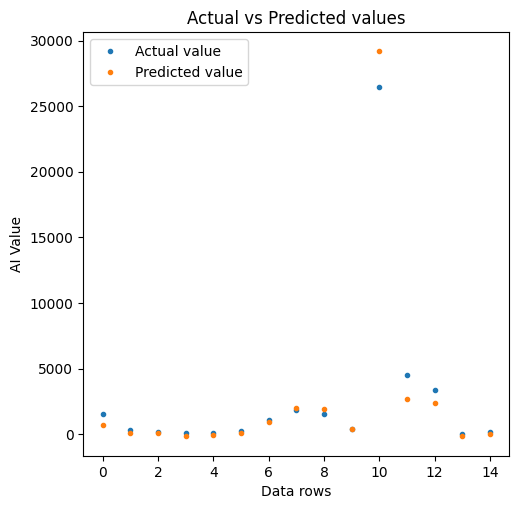

In [53]:
x_train, x_test, y_train, y_test, predicted_y_df = scale_split_fit_score(units, MinMaxScaler(), LinearRegression(fit_intercept=False))

Scores are terrible and weights look nothing like the expectations. Time to optimize. Lets try to optimize without weight penalties and learning rate decay. If the weights are very imbalanced a penalty to the cost function will be applied.

Iteration number 0: a = [4.37363100e-05 4.14989032e-03 4.14406655e-03 3.74290350e-06
 4.66434480e-06 1.23284040e-06]
                 b = 0
                 cost = 70157505.20634921

Iteration number 1: a = [8.74725820e-05 8.27175075e-03 8.26012703e-03 7.48580696e-06
 9.32868951e-06 2.46568080e-06]
                 b = 0
                 cost = 68349845.1850392

Iteration number 2: a = [1.31208816e-04 1.23657706e-02 1.23483707e-02 1.12287104e-05
 1.39930341e-05 3.69852119e-06]
                 b = 0
                 cost = 66578705.03737885

Iteration number 3: a = [1.74945012e-04 1.64321379e-02 1.64089856e-02 1.49716137e-05
 1.86573786e-05 4.93136158e-06]
                 b = 0
                 cost = 64843510.70688821

Iteration number 4: a = [2.18681170e-04 2.04710395e-02 2.04421584e-02 1.87145171e-05
 2.33217231e-05 6.16420197e-06]
                 b = 0
                 cost = 63143696.42344773

Iteration number 5: a = [2.62417289e-04 2.44826608e-02 2.44480745e-02 2.24574204e-05
 

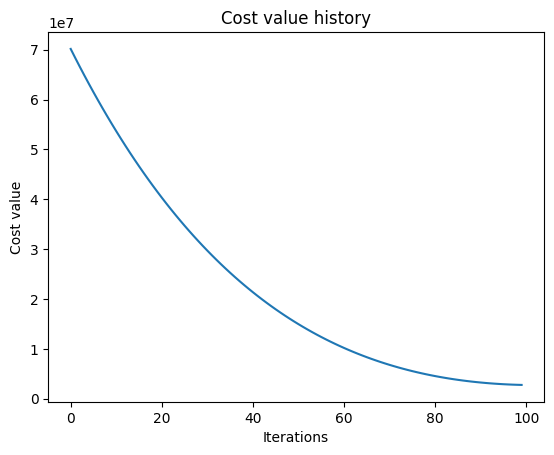

Resulting weights : [4.37344266e-03 3.02427032e-01 3.01952691e-01 3.74290140e-04
 4.66434017e-04 1.23284025e-04] and bias : 0
(array([4.37344266e-03, 3.02427032e-01, 3.01952691e-01, 3.74290140e-04,
       4.66434017e-04, 1.23284025e-04]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,1518,1658.742456,-140.742456,-9.271572
1,312,456.887484,-144.887484,-46.438296
2,154,103.132533,50.867467,33.030823
3,78,45.980139,32.019861,41.051104
4,60,57.156859,2.843141,4.738569
5,252,207.385038,44.614962,17.704350
6,1068,2040.015044,-972.015044,-91.012645
7,1848,2067.711702,-219.711702,-11.889161
8,1547,1684.446602,-137.446602,-8.884719
9,380,456.931662,-76.931662,-20.245174


Sum of absolute error on test data : 13940.870964083937


In [54]:
weights_1, bias_1 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.0000000000189, False, False, True),
                                             True)

Weights seem balanced and **att** and **def** form a greater part of the result considering the weights. Lets try again but with learning rate and try to reach a lower cost.

Iteration number 0: a = [8.56213476e-05 8.12412391e-03 8.11272287e-03 7.32737722e-06
 9.13125702e-06 2.41349708e-06]
                 b = 0
                 cost = 70157505.20634921

Iteration number 1: a = [1.70386337e-04 1.60606568e-02 1.60380592e-02 1.45814805e-05
 1.81712011e-05 4.80285918e-06]
                 b = 0
                 cost = 66641718.63695044

Iteration number 2: a = [2.54294974e-04 2.38141781e-02 2.37805851e-02 2.17623099e-05
 2.71198323e-05 7.16808629e-06]
                 b = 0
                 cost = 63297998.81564458

Iteration number 3: a = [3.37347261e-04 3.13891339e-02 3.13447438e-02 2.88698653e-05
 3.59771506e-05 9.50917843e-06]
                 b = 0
                 cost = 60118122.965679355

Iteration number 4: a = [4.19543203e-04 3.87898414e-02 3.87348495e-02 3.59041468e-05
 4.47431559e-05 1.18261356e-05]
                 b = 0
                 cost = 57094269.06635892

Iteration number 5: a = [5.00882804e-04 4.60204928e-02 4.59550911e-02 4.28651544e-05

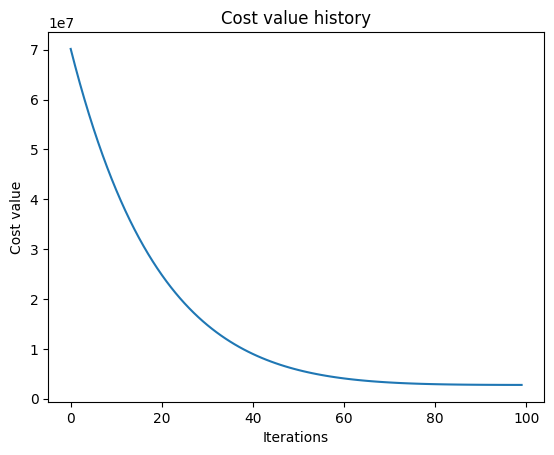

Resulting weights : [4.32369459e-03 3.00236429e-01 2.99766103e-01 3.70032345e-04
 4.61128028e-04 1.21881588e-04] and bias : 0
(array([4.32369459e-03, 3.00236429e-01, 2.99766103e-01, 3.70032345e-04,
       4.61128028e-04, 1.21881588e-04]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,1518,1646.727754,-128.727754,-8.480089
1,312,453.578259,-141.578259,-45.377647
2,154,102.385309,51.614691,33.516033
3,78,45.647002,32.352998,41.478202
4,60,56.742767,3.257233,5.428721
5,252,205.882720,46.117280,18.300508
6,1068,2025.239370,-957.239370,-89.629154
7,1848,2052.734306,-204.734306,-11.078696
8,1547,1672.245229,-125.245229,-8.096007
9,380,453.621935,-73.621935,-19.374193


Sum of absolute error on test data : 14043.670497430727


In [55]:
weights_2, bias_2 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.000000000037, True, False, True),
                                             True)

**Conclusion :** Both models reach local minimums. Their costs on the training data, predictions on the testing data, and weights and biases are similar. There are units that have somewhat good predictions and such that have terrible predictions. The latter are usually with greater **ai_value**. May be the whole dataset is not suitable for such a model. Lets take a look at a different one.

#### 4.2. Fractions below level 7 model :

In [56]:
add_transformed_data(fractions_below_level_7)

,index,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities,att_exp,def_exp
0,0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,14,80,60,0,Immunetojousting,64,125
1,1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,14,115,75,0,Immunetojousting,216,125
2,2,Archer,Castle,Ranged,2,6,3,2,3,10,4,9,126,100,0,Ranged(12shots),216,27
3,3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,9,184,150,0,"Ranged(24shots),Doubleattack",216,27
4,4,Griffin,Castle,Flying,3,8,8,3,6,25,6,7,351,200,0,"Flying,Tworetaliations",512,512
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,119,EnergyElemental,Conflux,Flying,4+*,12,8,4,6,35,8,5,470,400,0,"Elemental,Flying,Icevulnerability,Fireimmunity...",1728,512
104,120,EarthElemental,Conflux,Warrior,5,10,10,4,8,40,4,4,330,400,0,"Elemental,MeteorShowervulnerability,Lightninga...",1000,1000
105,121,MagmaElemental,Conflux,Warrior,5+*,11,11,6,10,40,6,4,490,500,0,"Elemental,MeteorShowervulnerability,Lightninga...",1331,1331
106,122,PsychicElemental,Conflux,Warrior,6,15,13,10,20,75,7,2,1669,750,0,"Elemental,Noenemyretaliation,Attacksadjacenthexes",3375,2197


Shape of variables array : (108, 6)
Shape of target vector : (108,)

Score on training data : 0.9508980043334844
Score on testing data : 0.9624256014632399

Model coefficients :
  hp = 7.8715135218086445
  att_exp = 0.14248816401899148
  def_exp = 0.019319950600207664
  min_dmg = 34.10949189232233
  max_dmg = -4.844672310541914
  speed = -2.7848563067401546
Model intercept = 0.0



,Actual value,Predicted value,Signed difference,Relative difference %
0,848,864.026386,-16.026386,-1.889904
1,884,940.879606,-56.879606,-6.434345
2,1518,1471.762057,46.237943,3.045978
3,154,141.415291,12.584709,8.171889
4,356,324.713565,31.286435,8.788325
5,714,731.181197,-17.181197,-2.406330
6,78,62.616380,15.383620,19.722590
7,1946,1704.285315,241.714685,12.421104
8,330,563.209819,-233.209819,-70.669642
9,1079,930.267320,148.732680,13.784308



Sum of absolute error on test data : 824.3726753220458



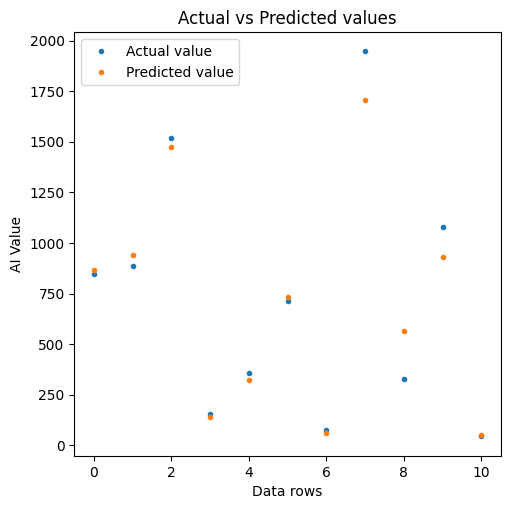

In [57]:
x_train, x_test, y_train, y_test, predicted_y_df = scale_split_fit_score(fractions_below_level_7, MinMaxScaler(), LinearRegression(fit_intercept=False))

Weights look like they need an update. Again the higher values are not well predicted. Lets see what some optimization will bring, but without learning rate decay and regularization :

Iteration number 0: a = [1.02245363e-04 4.06662033e-03 3.15824308e-03 1.88616804e-05
 2.66028606e-05 1.16057431e-05]
                 b = 0
                 cost = 784142.2783505154

Iteration number 1: a = [2.04490159e-04 8.09683906e-03 6.29775409e-03 3.77233572e-05
 5.32057112e-05 2.32114848e-05]
                 b = 0
                 cost = 763241.4955136604

Iteration number 2: a = [3.06734390e-04 1.20909820e-02 9.41864413e-03 5.65850305e-05
 7.98085518e-05 3.48172252e-05]
                 b = 0
                 cost = 742799.805489357

Iteration number 3: a = [4.08978053e-04 1.60493722e-02 1.25210237e-02 7.54467001e-05
 1.06411382e-04 4.64229643e-05]
                 b = 0
                 cost = 722808.9902603455

Iteration number 4: a = [5.11221151e-04 1.99723295e-02 1.56050025e-02 9.43083661e-05
 1.33014203e-04 5.80287020e-05]
                 b = 0
                 cost = 703260.9704723632

Iteration number 5: a = [6.13463682e-04 2.38601712e-02 1.86706897e-02 1.13170029e-04
 

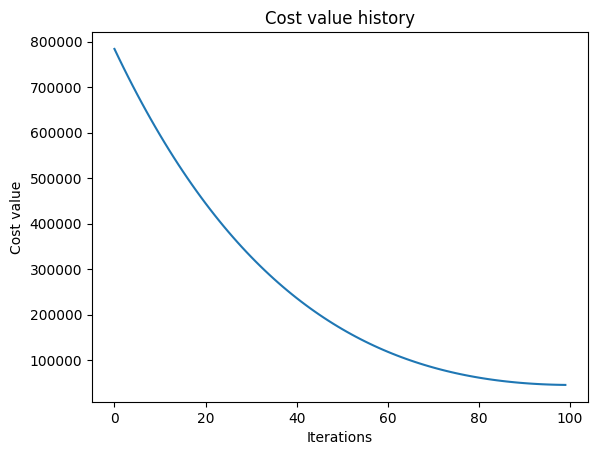

Resulting weights : [0.01022173 0.26944304 0.23875065 0.00188615 0.00266024 0.00116057] and bias : 0
(array([0.01022173, 0.26944304, 0.23875065, 0.00188615, 0.00266024,
       0.00116057]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,848,831.085950,16.914050,1.994581
1,884,878.642770,5.357230,0.606022
2,1518,1395.304243,122.695757,8.082724
3,154,88.206122,65.793878,42.723297
4,356,370.761920,-14.761920,-4.146607
5,714,878.613605,-164.613605,-23.055127
6,78,40.193087,37.806913,48.470402
7,1946,1716.278792,229.721208,11.804790
8,330,508.636026,-178.636026,-54.132129
9,1079,831.194648,247.805352,22.966205


Sum of absolute error on test data : 1114.3319744238008


In [58]:
weights_3, bias_3 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.00000000126, False, False, True),
                                             True)

Weights look balanced, but most of the result again comes from **att** and **def**. Accuracy is still a problem, but variance looks 'centered'. Lets see if a more optimal point will be reached with the use of learning rate decay :

Iteration number 0: a = [2.15851322e-04 8.58508737e-03 6.66740205e-03 3.98191031e-05
 5.61615946e-05 2.45010132e-05]
                 b = 0
                 cost = 784142.2783505154

Iteration number 1: a = [4.29541631e-04 1.69237119e-02 1.31854800e-02 7.92399993e-05
 1.11761529e-04 4.87570103e-05]
                 b = 0
                 cost = 740369.4476579742

Iteration number 2: a = [6.41071004e-04 2.50236826e-02 1.95577360e-02 1.18262689e-04
 1.66799805e-04 7.27679915e-05]
                 b = 0
                 cost = 699030.8424748165

Iteration number 3: a = [8.50439514e-04 3.28925256e-02 2.57875734e-02 1.56887173e-04
 2.21276423e-04 9.65339570e-05]
                 b = 0
                 cost = 659993.0116032299

Iteration number 4: a = [0.00105765 0.0405375  0.0318783  0.00019511 0.00027519 0.00012005]
                 b = 0
                 cost = 623130.049888936

Iteration number 5: a = [0.00126269 0.04796558 0.03783313 0.00023294 0.00032854 0.00014333]
                 b 

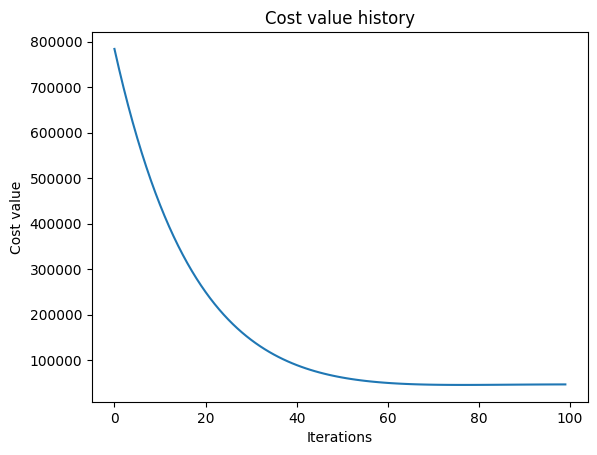

Resulting weights : [0.01089732 0.2804255  0.25030047 0.00201084 0.0028361  0.00123729] and bias : 0
(array([0.01089732, 0.2804255 , 0.25030047, 0.00201084, 0.0028361 ,
       0.00123729]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,848,866.788616,-18.788616,-2.215639
1,884,917.610539,-33.610539,-3.802097
2,1518,1457.187059,60.812941,4.006123
3,154,92.032807,61.967193,40.238437
4,356,387.207033,-31.207033,-8.766020
5,714,917.579447,-203.579447,-28.512528
6,78,41.882130,36.117870,46.304961
7,1946,1792.399589,153.600411,7.893135
8,330,531.197539,-201.197539,-60.968951
9,1079,866.904499,212.095501,19.656673


Sum of absolute error on test data : 1042.5912669968905


In [59]:
weights_4, bias_4 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.00000000266, True, False, True),
                                             True)

**Conclusion :** Both models reach local minimums. Their costs on the training data, predictions on the testing data, and weights and biases are similar. There are units that have somewhat good predictions and such that have terrible predictions. Lets make one final experiment and use a dataset only of creatures which have no special abilities.

#### 4.3. Units with no special abilities :

First - form the dataset :

In [60]:
no_abilities = fractions[fractions.abilities == '-']

# Fix the indexes
no_abilities = no_abilities.reset_index(drop=False)
no_abilities

,index,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities
0,6,Swordsman,Castle,Warrior,4,10,12,6,9,35,5,4,445,300,0,-
1,14,Centaur,Rampart,Warrior,1,5,3,2,3,8,6,14,100,70,0,-
2,15,CentaurCaptain,Rampart,Warrior,1+,6,3,2,3,10,8,14,138,90,0,-
3,28,Gremlin,Tower,Warrior,1,3,3,1,2,4,4,16,44,30,0,-
4,42,Imp,Inferno,Warrior,1,2,3,1,2,4,5,15,50,50,0,-
5,46,HellHound,Inferno,Warrior,3,10,6,2,7,25,7,5,357,200,0,-
6,48,Demon,Inferno,Warrior,4,10,10,7,9,35,5,4,445,250,0,-
7,49,HornedDemon,Inferno,Warrior,4+,10,10,7,9,40,6,4,480,270,0,-
8,50,PitFiend,Inferno,Warrior,5,13,13,13,17,45,6,3,765,500,0,-
9,84,Goblin,Stronghold,Warrior,1,4,2,1,2,5,5,15,60,40,0,-


By now we know the drill :

In [61]:
add_transformed_data(no_abilities)

,index,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,growth,ai_value,gold,resources,abilities,att_exp,def_exp
0,6,Swordsman,Castle,Warrior,4,10,12,6,9,35,5,4,445,300,0,-,1000,1728
1,14,Centaur,Rampart,Warrior,1,5,3,2,3,8,6,14,100,70,0,-,125,27
2,15,CentaurCaptain,Rampart,Warrior,1+,6,3,2,3,10,8,14,138,90,0,-,216,27
3,28,Gremlin,Tower,Warrior,1,3,3,1,2,4,4,16,44,30,0,-,27,27
4,42,Imp,Inferno,Warrior,1,2,3,1,2,4,5,15,50,50,0,-,8,27
5,46,HellHound,Inferno,Warrior,3,10,6,2,7,25,7,5,357,200,0,-,1000,216
6,48,Demon,Inferno,Warrior,4,10,10,7,9,35,5,4,445,250,0,-,1000,1000
7,49,HornedDemon,Inferno,Warrior,4+,10,10,7,9,40,6,4,480,270,0,-,1000,1000
8,50,PitFiend,Inferno,Warrior,5,13,13,13,17,45,6,3,765,500,0,-,2197,2197
9,84,Goblin,Stronghold,Warrior,1,4,2,1,2,5,5,15,60,40,0,-,64,8


Shape of variables array : (16, 6)
Shape of target vector : (16,)

Score on training data : 0.9859362055935661
Score on testing data : -0.7332175359414574

Model coefficients :
  hp = 4.925984959082463
  att_exp = 0.013293885460334803
  def_exp = 0.09886765860728061
  min_dmg = -4.45916327086868
  max_dmg = 18.231411058122568
  speed = 1.837252552108891
Model intercept = 0.0



,Actual value,Predicted value,Signed difference,Relative difference %
0,480,453.093014,26.906986,5.605622
1,445,426.625837,18.374163,4.129025



Sum of absolute error on test data : 45.281148606342015



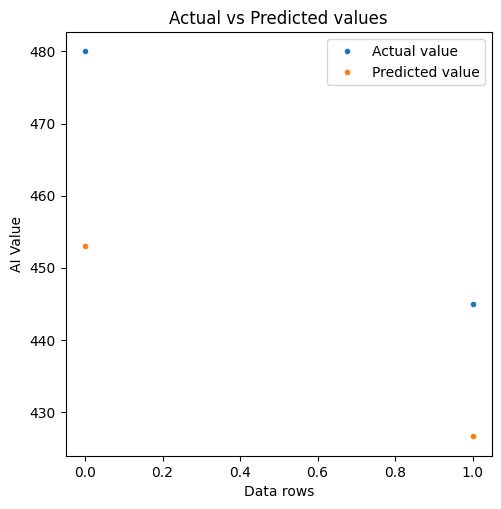

In [62]:
x_train, x_test, y_train, y_test, predicted_y_df = scale_split_fit_score(no_abilities, MinMaxScaler(), LinearRegression(fit_intercept=False))

Weights are imbalanced and variance is big. Optimization has to take place. Lets try without penalty and without learning rate decay :

Iteration number 0: a = [7.59421100e-05 2.32988265e-03 2.73790845e-03 1.47154500e-05
 2.16648100e-05 1.05247400e-05]
                 b = 0
                 cost = 139082.5

Iteration number 1: a = [1.51883786e-04 4.64388666e-03 5.45319692e-03 2.94308968e-05
 4.33296098e-05 2.10494775e-05]
                 b = 0
                 cost = 135619.81860474282

Iteration number 2: a = [2.27825027e-04 6.94212025e-03 8.14605231e-03 4.41463403e-05
 6.49943994e-05 3.15742126e-05]
                 b = 0
                 cost = 132228.66606155748

Iteration number 3: a = [3.03765834e-04 9.22469089e-03 1.08166599e-02 5.88617807e-05
 8.66591789e-05 4.20989452e-05]
                 b = 0
                 cost = 128907.80805168634

Iteration number 4: a = [3.79706206e-04 1.14917053e-02 1.34652036e-02 7.35772178e-05
 1.08323948e-04 5.26236753e-05]
                 b = 0
                 cost = 125656.03026215768

Iteration number 5: a = [4.55646144e-04 1.37432696e-02 1.60918656e-02 8.82926517e-05
 1.29

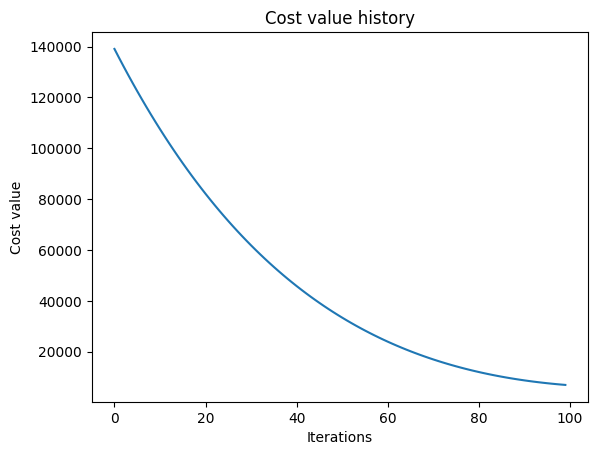

Resulting weights : [0.00759206 0.16933665 0.18683383 0.00147153 0.00216643 0.00105246] and bias : 0
(array([0.00759206, 0.16933665, 0.18683383, 0.00147153, 0.00216643,
       0.00105246]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,480,356.510269,123.489731,25.727027
1,445,356.471256,88.528744,19.894100


Sum of absolute error on test data : 212.01847436574872


In [63]:
weights_5, bias_5 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.00000000371, False, False, True),
                                             True)

Weights look much better now. Accuracy is still bad, but variance seems more 'centered'. Lets see the outcome of applying learning rate decay :

Iteration number 0: a = [1.47380914e-04 4.52160514e-03 5.31346114e-03 2.85582857e-05
 4.20449143e-05 2.04253714e-05]
                 b = 0
                 cost = 139082.5

Iteration number 1: a = [2.93286400e-04 8.93878824e-03 1.04894456e-02 5.68309766e-05
 8.36693415e-05 4.06464799e-05]
                 b = 0
                 cost = 132404.05800398564

Iteration number 2: a = [4.37716505e-04 1.32540989e-02 1.55318173e-02 8.48180729e-05
 1.24873283e-04 6.06633258e-05]
                 b = 0
                 cost = 126055.85406034306

Iteration number 3: a = [5.80671278e-04 1.74700125e-02 2.04443142e-02 1.12519575e-04
 1.65656739e-04 8.04759093e-05]
                 b = 0
                 cost = 120021.37382194278

Iteration number 4: a = [0.00072215 0.02158893 0.02523055 0.00013994 0.00020602 0.00010008]
                 b = 0
                 cost = 114284.96090317884

Iteration number 5: a = [0.00086216 0.02561319 0.02989403 0.00016707 0.00024596 0.00011949]
                 b = 0


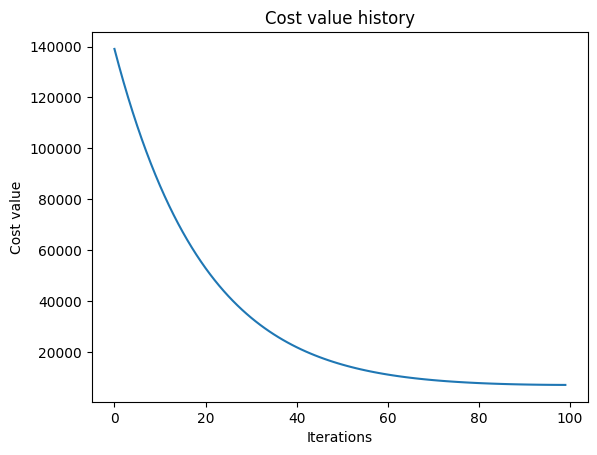

Resulting weights : [0.00744068 0.16708833 0.18457182 0.00144218 0.00212322 0.00103147] and bias : 0
(array([0.00744068, 0.16708833, 0.18457182, 0.00144218, 0.00212322,
       0.00103147]), 0)



,Actual value,Predicted value,Signed difference,Relative difference %
0,480,351.993173,128.006827,26.668089
1,445,351.954938,93.045062,20.909003


Sum of absolute error on test data : 221.05188890888246


In [64]:
weights_6, bias_6 = optimize_and_score_model(x_train, x_test, y_train, y_test,
                                             gradient_descent(x_train, y_train, 100, 0.0000000072, True, False, True),
                                             True)

**Conclusion :** Both models reach local minimums. Their costs on the training data, predictions on the testing data, and weights and biases are similar. Unfortunately none of the datasets and models could prove the hypothesys.

Lets have a look of the results from all the models built.

In [65]:
print("All fractions results :")
print(f"Weights : {weights_1}, bias = {bias_1}")
print(f"Weights : {weights_2}, bias = {bias_2}")

print()

print("Units below level 7 results :")
print(f"Weights : {weights_3}, bias = {bias_3}")
print(f"Weights : {weights_4}, bias = {bias_4}")

print()

print("Units without abilities results :")
print(f"Weights : {weights_5}, bias = {bias_5}")
print(f"Weights : {weights_6}, bias = {bias_6}")

All fractions results :
Weights : [4.37344266e-03 3.02427032e-01 3.01952691e-01 3.74290140e-04
 4.66434017e-04 1.23284025e-04], bias = 0
Weights : [4.32369459e-03 3.00236429e-01 2.99766103e-01 3.70032345e-04
 4.61128028e-04 1.21881588e-04], bias = 0

Units below level 7 results :
Weights : [0.01022173 0.26944304 0.23875065 0.00188615 0.00266024 0.00116057], bias = 0
Weights : [0.01089732 0.2804255  0.25030047 0.00201084 0.0028361  0.00123729], bias = 0

Units without abilities results :
Weights : [0.00759206 0.16933665 0.18683383 0.00147153 0.00216643 0.00105246], bias = 0
Weights : [0.00744068 0.16708833 0.18457182 0.00144218 0.00212322 0.00103147], bias = 0


Looking at the last 2 groups of results it seems logical to try and set the weights in a more human way just to see what will come out of it :

In [66]:
a_att = 0.25
a_def = 0.25
a_min_dmg = 0.002
a_max_dmg = 0.003
a_hp = 0.1 
a_speed = 0.001

predicted = units

# Remove unneeded columns.
predicted = predicted.drop(['growth', 'resources'], axis = 1)

# Set the columns in a better order.
predicted = predicted[['unit', 'town', 'type', 'level', 'att', 'def', 'min_dmg', 'max_dmg', 'hp', 'speed', 'abilities', 'att_exp', 'def_exp', 'gold', 'ai_value']]

predicted['prediced_ai_value'] = a_hp*predicted['hp'] + a_att*predicted['att_exp'] + a_def*predicted['def_exp'] + a_min_dmg*predicted['min_dmg'] + a_max_dmg*predicted['max_dmg'] + a_speed*predicted['speed']
predicted['signed_difference'] = predicted['ai_value'] - predicted['prediced_ai_value']
predicted['relative_difference_%'] = 100*(predicted['ai_value'] - predicted['prediced_ai_value'])/predicted['ai_value']

with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 2,):
    display(predicted)

,unit,town,type,level,att,def,min_dmg,max_dmg,hp,speed,abilities,att_exp,def_exp,gold,ai_value,prediced_ai_value,signed_difference,relative_difference_%
0,Pikeman,Castle,Warrior,1,4,5,1,3,10,4,Immunetojousting,64,125,60,80,48.27,31.73,39.67
1,Halberdier,Castle,Warrior,1+,6,5,2,3,10,5,Immunetojousting,216,125,75,115,86.27,28.73,24.98
2,Archer,Castle,Ranged,2,6,3,2,3,10,4,Ranged(12shots),216,27,100,126,61.77,64.23,50.98
3,Marksman,Castle,Ranged,2+,6,3,2,3,10,6,"Ranged(24shots),Doubleattack",216,27,150,184,61.77,122.23,66.43
4,Griffin,Castle,Flying,3,8,8,3,6,25,6,"Flying,Tworetaliations",512,512,200,351,258.53,92.47,26.34
5,RoyalGriffin,Castle,Flying,3+,9,9,3,6,25,9,"Flying,Unlimitedretaliations",729,729,240,448,367.03,80.97,18.07
6,Swordsman,Castle,Warrior,4,10,12,6,9,35,5,-,1000,1728,300,445,685.54,-240.54,-54.05
7,Crusader,Castle,Warrior,4+,12,12,7,10,35,6,Doubleattack,1728,1728,400,558,867.55,-309.55,-55.47
8,Monk,Castle,Ranged,5,12,7,10,12,30,5,Ranged(12shots),1728,343,400,485,520.81,-35.81,-7.38
9,Zealot,Castle,Ranged,5+,12,10,10,12,30,7,"Ranged(24shots),Nomeleepenalty",1728,1000,450,750,685.06,64.94,8.66


Results clearly show that this is not the right formula, as its not accurate and has no determined way to account for a unit's ***abilities***. 

### 5. Conclusion
After the analysis and modelling it seems that there is some truth to the hypothesis. Even the data itself suggests it - for instance, if you compare ***Archer*** with ***Marksman*** and ***WoodElf*** with ***GrandElf*** you will see that the main difference is the special ability - **double attack**. And is does NOT scale equaly in both of cases. This hints that a formula may not exist at all.

After searching for additional [info](https://heroes.thelazy.net/index.php/AI_value), it turns out that with the different patches some of the units have received updates only on their "ai_value". This probably means that the other units have gone through the same in earlier stages. This means a model will never be precise enough. The other tasks - cost evaluation and modelling a new unit, will not  be furthered.

Nevertheless this exercise showed a result, even though its not optimal and showed a way to navigate through a small dataset with some hidden problems.

Thank you for your time, I hope you enjoyed it!